# Introduction to CREsted with peak regression

In this introductory notebook, we will train a peak regression model on mouse cortex data and inspect the results to get a feel for the capabilities of the CREsted package.  

In [1]:
# Set package settings
import matplotlib
import os

## Set the font type to ensure text is saved as whole words
matplotlib.rcParams["pdf.fonttype"] = 42  # Use TrueType fonts instead of Type 3 fonts
matplotlib.rcParams["ps.fonttype"] = 42  # For PostScript as well, if needed

## Set the base directory for data retrieval with crested.get_dataset()/get_model()
os.environ['CRESTED_DATA_DIR'] = '/staging/leuven/stg_00002/lcb/cblaauw/'

## Importing data

For this tutorial, we will use the mouse BICCN dataset which is available in the {func}`~crested.get_dataset` function.  
To train a CREsted peak regression model on your data, you need: 
1. A consensus regions BED file containing all the regions of interest across cell types.
2. A folder containing the bigwig files per cell type, or a list of bigwig files.
3. A genome fasta file and optionally a chromosome sizes file.

You could use a tool like SnapATAC2 or pycisTopic to generate the consensus regions and bigwig files from your own data.

In [2]:
import anndata as ad
import crested
import numpy as np
import matplotlib.pyplot as plt
import keras

2026-02-16 17:11:58.043069: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-16 17:12:07.698733: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-16 17:13:00.734150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


By loading our genome in the {class}`crested.Genome` class and setting it with {func}`~crested.register_genome`, the genome is automatically used in all functions throughout CREsted. If you don't provide the chromomsome sizes, they will be automatically calculated from the fasta.  
:::{note}
Any function or class that expects a genome object can still accept a genome object as explicit input even if one was already registered. In that case, the input will be used instead of the registered genome. 
:::

In [3]:
## Set the genome
genome = crested.Genome("mm10/genome.fa", "mm10/genome.chrom.sizes")
crested.register_genome(genome)  # Register the genome so that it's automatically used in every function

print(genome.fetch("chr1", 10000000, 10000010))

2026-02-16T17:13:59.533588+0100 INFO Genome genome registered.
TTTTCAATGC


For this tutorial we will be training on the 'cut sites', but the 'coverage' data are also available (an older version of the tutorial would train on the coverage).
Data is originally from [Zemke et al., Nature, 2023](https://doi.org/10.1038/s41586-023-06819-6).

Of course, if you have the data already available, you can specify the paths directly.

In [4]:
bigwigs_folder, regions_file = crested.get_dataset("mouse_cortex_bigwig_cut_sites")

# Alternatively, pass your paths manually
# You can also provide a list of paths or a dict of {class_name: path, ...} for bigwigs_folder
# bigwigs_folder = "crested/mouse_biccn/bigwigs_cut_sites.tar.gz.untar"
# regions_file = "crested/mouse_biccn/consensus_peaks_biccn.bed"

We can use the {func}`~crested.import_bigwigs` function to import bigwigs per cell type and a consensus regions BED file into an {class}`anndata.AnnData` object,
with the imported cell types as the `AnnData.obs` and the consensus peak regions as the `AnnData.var`.  

:::{hint}
`target` determines how the values within a region are combined (`'count'`, `'max'`, `'mean'`, ...).  
If your resulting values would be very low, like with the sparse data from cut sites bigwigs, we recommend using `'count'` (summing within each window). Otherwise, we recommend using `'mean'`.
:::

In [5]:
adata = crested.import_bigwigs(
    bigwigs_folder=bigwigs_folder,
    regions_file=regions_file,
    target_region_width=1000,  # optionally, use a different width than the regions file (here, 500bp) for the .X values calculation
    target="count",  # or "max", "mean", "logcount" --> what we will be predicting
)
adata

2026-02-16T17:15:17.442422+0100 INFO Extracting values from 19 bigWig files...


AnnData object with n_obs × n_vars = 19 × 546993
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'target_start', 'target_end'

To train a model, we always need to add a *split* column to our dataset, which we can do using {func}`crested.pp.train_val_test_split`.  
This will add a column to the `AnnData.var` with the split type for each region (train, val, or test).

In [6]:
# Choose the chromosomes for the validation and test sets
crested.pp.train_val_test_split(adata, strategy="chr", val_chroms=["chr8", "chr10"], test_chroms=["chr9", "chr18"])

# Alternatively, we can split randomly on the regions
# crested.pp.train_val_test_split(
#     adata, strategy="region", val_size=0.1, test_size=0.1, random_state=42
# )

print(adata.var["split"].value_counts())
adata.var.head(3)

2026-02-16T17:16:02.406066+0100 INFO Lazily importing module crested.pp. This could take a second...
split
train    440993
val       56064
test      49936
Name: count, dtype: int64


chr    start      end  target_start  target_end  split
region                                                                       
chr1:3094805-3095305  chr1  3094805  3095305       3094555     3095555  train
chr1:3095470-3095970  chr1  3095470  3095970       3095220     3096220  train
chr1:3112174-3112674  chr1  3112174  3112674       3111924     3112924  train

## Preprocessing

### Region width

For this example we're interested in training on wider regions than our consensus regions file (500bp), so that we also include some sequence information from the tails of our peaks.

Here, we'll change it to 2114 bp regions, since that is a known size that works well with the default {func}`crested.tl.zoo.dilated_cnn` model architecture we'll use. This is not fixed and can be adapted to what you prefer, as long as it is compatible with the model architecture. 

Wider regions will mean that you don't only include sequence information from the center of the peaks and could effectively increase your dataset size if the tails of the peak include meaningful information, but could also introduce noise if the tails are not informative.  
Wider regions will also increase the computational cost of training the model. 

In [7]:
crested.pp.change_regions_width(adata, width=2114)

### Peak normalization

Additionally, we can normalize our peak values based on the variability of the top peak heights per cell type using {func}`crested.pp.normalize_peaks`. 
This function applies a normalization scaling factor to each cell type, obtained by comparing the distribution of peak heights for the maximally accessible, aspecific regions per cell type.

The `top_k_percent` parameter can be tuned based on potential bias towards cell types. If some weights are overcompensating too much, consider increasing the top_k_percent. The default is 0.01, but here we'll use 0.03:

In [8]:
crested.pp.normalize_peaks(adata, top_k_percent=0.03)

2026-02-16T17:16:20.554363+0100 INFO Filtering on top k Gini scores...
2026-02-16T17:16:25.546554+0100 INFO Added normalization weights to adata.obsm['weights']...


chr     start       end  target_start  target_end  \
region                                                                         
chr5:76656624-76658738    chr5  76656624  76658738      76657181    76658181   
chr13:30900787-30902901  chr13  30900787  30902901      30901344    30902344   
chr9:65586049-65588163    chr9  65586049  65588163      65586606    65587606   
chr9:65586556-65588670    chr9  65586556  65588670      65587113    65588113   
chr9:65587095-65589209    chr9  65587095  65589209      65587652    65588652   
...                        ...       ...       ...           ...         ...   
chr9:65459289-65461403    chr9  65459289  65461403      65459846    65460846   
chr9:65459852-65461966    chr9  65459852  65461966      65460409    65461409   
chr5:76587680-76589794    chr5  76587680  76589794      76588237    76589237   
chr9:65523082-65525196    chr9  65523082  65525196      65523639    65524639   
chr19:18337654-18339768  chr19  18337654  18339768      18338211    18339211   

                         split  
region                          
chr5:76656624-76658738   train  
chr13:30900787-30902901  train  
chr9:65586049-65588163    test  
chr9:65586556-65588670    test  
chr9:65587095-65589209    test  
...                        ...  
chr9:65459289-65461403    test  
chr9:65459852-65461966    test  
chr5:76587680-76589794   train  
chr9:65523082-65525196    test  
chr19:18337654-18339768  train  

[48308 rows x 6 columns]

We can visualize the normalization factor for each cell type using the {func}`crested.pl.qc.normalization_weights` function to inspect which cell type peaks were up/down weighted.

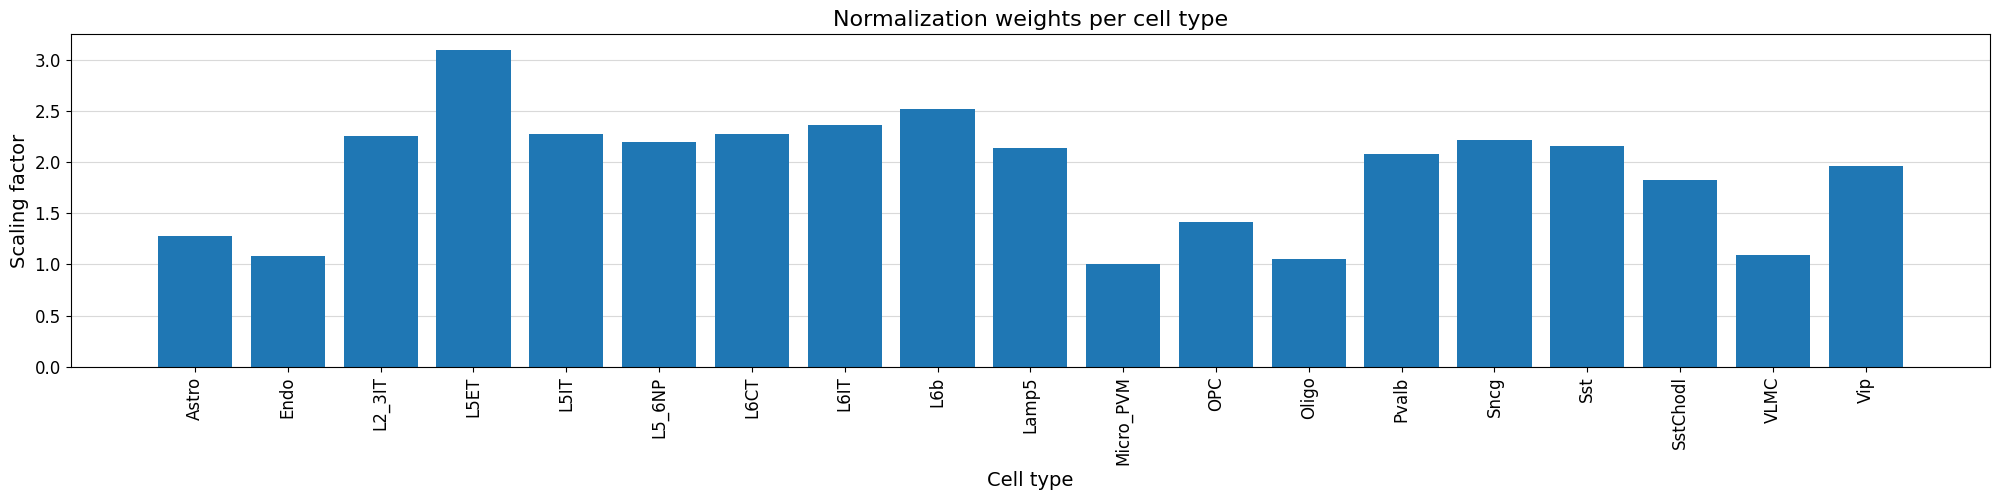

In [11]:
%matplotlib inline
crested.pl.qc.normalization_weights(adata, title="Normalization weights per cell type", xtick_rotation=90)

To get a feeling for our data, we can also look at the self-correlation between classes. If there are certain classes that very strongly anti-correlate with everything else, this can be a sign of low-quality data or strong outliers that might hinder training.

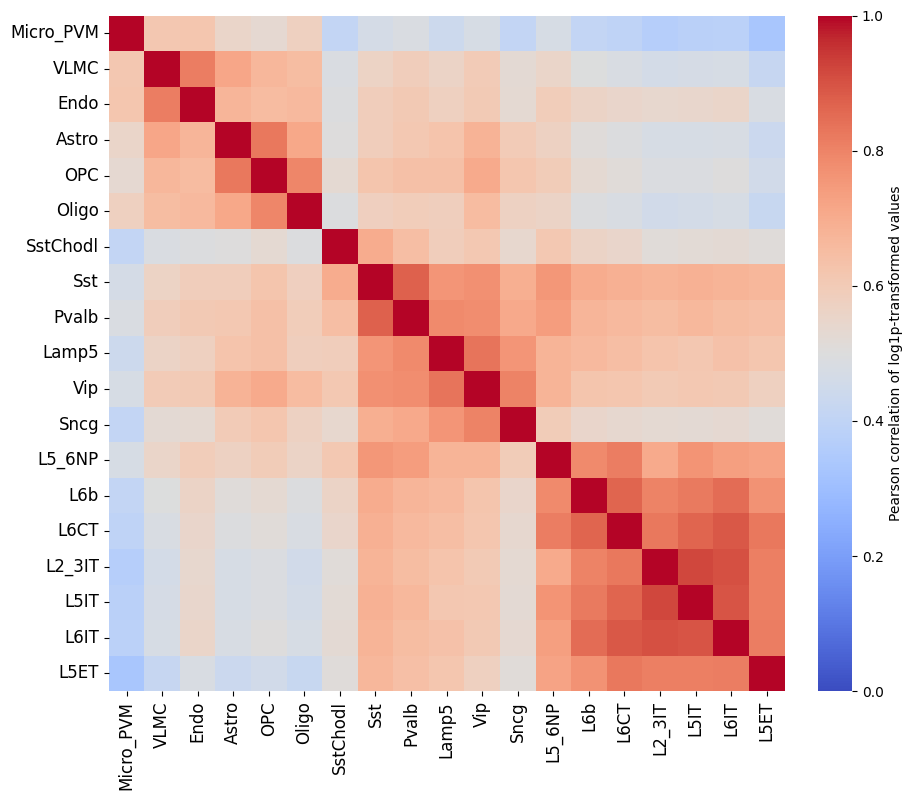

In [12]:
%matplotlib inline
crested.pl.corr.heatmap_self(adata, log_transform=True, vmin=0, vmax=1, reorder=True)

This dataset looks ready to go: there's no crazy outlier classes, and robust differences between the different classes. We do see higher correlations between the profiles of different excitatory neurons, but this is expected biologically.

In [13]:
# Save the final preprocessing results
adata.write_h5ad("crested/mouse_cortex.h5ad")

There is no single best way to preprocess your data, so we recommend experimenting with different preprocessing steps to see what works best for your data.  
Likewise there is no single best training approach, so we recommend experimenting with different training strategies.

## Model training

The CREsted training workflow is built around the {func}`crested.tl.Crested` class.
This class has a couple of required arguments:
- `data`: the {class}`crested.tl.data.AnnDataModule` object containing all the data (anndata, genome) and dataloaders that specify how to load the data.
- `model`: the {class}`keras.Model` object containing the model architecture.
- `config`: the {class}`crested.tl.TaskConfig` object containing the optimizer, loss function, and metrics to use in training.  

Since training can take a long time, it's often better to run these steps in a script or a python file, so you could run it on a cluster or in the background.

### Data

We'll start by initializing the {class}`crested.tl.data.AnnDataModule` object with our data.  
This will tell our model how to load the data and what data to load during fitting/evaluation.
The main arguments to supply are the `adata` object, the `genome` object (if you didn't register one), and the `batch_size`.  
Other optional arguments are related to the training data loading (e.g. shuffling, whether to load the sequences into memory, ...).

In [12]:
datamodule = crested.tl.data.AnnDataModule(
    adata,
    batch_size=128,  # lower this if you encounter OOM errors
    max_stochastic_shift=3,  # optional data augmentation to slightly reduce overfitting
    always_reverse_complement=True,  # default True. Will double the effective size of the training dataset.
)

### Model definition 

Next, we'll define the model architecture. This is a standard Keras model definition, so you can provide your own model definition if you like.  
Alternatively, there are a couple of ready-to-use models available in the `crested.tl.zoo` module.  
Each of them require the width of the input sequences and the number of output classes (your `adata.obs`) as arguments.

In [13]:
# Load a dilated cnn architecture for a dataset with 2114bp regions and 19 cell types
model = crested.tl.zoo.dilated_cnn(seq_len=2114, num_classes=adata.n_obs)

2026-02-14 21:01:27.482223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78751 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:c6:00.0, compute capability: 9.0


### TaskConfig

The TaskConfig object specifies the optimizer, loss function, and metrics to use in training (we call this our 'task').  
Some default configurations are available for some common tasks such as 'topic_classification' and 'peak_regression',
which you can load using the {func}`crested.tl.default_configs` function.  

:::{hint}
If using mean values with {func}`crested.tl.losses.CosineMSELogLoss`, we recommend setting the multiplier to the number of basepairs you're averaging over (your `target_region_width`), which here is 1000. Default config `'peak_regression_mean'` automatically uses `multiplier=1000` for this reason.
:::

Alternatively, you can create your own TaskConfig object and specify the optimizer, loss function, and metrics yourself if you want to do something completely custom.  
Here, we replicate the values from `crested.tl.default_configs("peak_regression_count")` manually:

In [ ]:
# Load the default configuration for training a peak regression model on cutsites
config = crested.tl.default_configs("peak_regression_count")  # or "peak_regression_mean"/"topic_classification"

# Or create your own:
# optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# loss = crested.tl.losses.CosineMSELogLoss(max_weight=100, multiplier=1)
# metrics = [
#     keras.metrics.MeanAbsoluteError(),
#     keras.metrics.MeanSquaredError(),
#     keras.metrics.CosineSimilarity(axis=1),
#     crested.tl.metrics.PearsonCorrelation(),
#     crested.tl.metrics.ConcordanceCorrelationCoefficient(),
#     crested.tl.metrics.PearsonCorrelationLog(),
# ]
# config = crested.tl.TaskConfig(optimizer, loss, metrics)

print(config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x146fa6a71910>, loss=CosineMSELogLoss: {'name': 'CosineMSELogLoss', 'reduction': 'sum_over_batch_size', 'max_weight': 100}, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>])


### Training

Now we're ready to train our model.
We'll create a {class}`~crested.tl.Crested` object with the data, model, and config objects we just created.  
Then, we can call the {meth}`~crested.tl.Crested.fit` method to train the model.  
Read the documentation for more information on all available arguments to customize your training (e.g. augmentations, early stopping, checkpointing, ...).  

By default: 
1. The model will continue training until the validation loss stops decreasing for 10 epochs with a maximum of 100 epochs.  
2. Every best model is saved based on the validation loss.
3. The learning rate reduces by a factor of 0.25 if the validation loss stops decreasing for 5 epochs.

```{note}
If you specify the same project_name and run_name as a previous run, then CREsted will assume that you want to continue training and will load the last available model checkpoint from the {project_name}/{run_name} folder and continue from that epoch.
```

In [ ]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model,
    config=config,
    project_name="mouse_biccn",  # change to your liking
    run_name="base_model",  # change to your liking
    logger="wandb",  # or None, 'dvc', 'tensorboard'
    seed=7,  # For reproducibility
)

In [ ]:
# train the model
trainer.fit(
    epochs=60,
    learning_rate_reduce_patience=3,
    early_stopping_patience=6,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cas-blaauw. Use `wandb login --relogin` to force relogin


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 2114, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2114, 512) │     10,240 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2114, 512) │      2,048 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2114, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2114, 512) │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1conv         │ (None, 2110, 512) │    786,432 │ dropout[0][0]     │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1bn           │ (None, 2110, 512) │      2,048 │ bpnet_1conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1activation   │ (None, 2110, 512) │          0 │ bpnet_1bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1crop         │ (None, 2110, 512) │          0 │ dropout[0][0]     │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2110, 512) │          0 │ bpnet_1activatio… │
│                     │                   │            │ bpnet_1crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1dropout      │ (None, 2110, 512) │          0 │ add[0][0]         │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2conv         │ (None, 2102, 512) │    786,432 │ bpnet_1dropout[0… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2bn           │ (None, 2102, 512) │      2,048 │ bpnet_2conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2activation   │ (None, 2102, 512) │          0 │ bpnet_2bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2crop         │ (None, 2102, 512) │          0 │ bpnet_1dropout[0… │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2102, 512) │          0 │ bpnet_2activatio… │
│                     │                   │            │ bpnet_2crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2dropout      │ (None, 2102, 512) │          0 │ add_1[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,329,875 (24.15 MB)

 Trainable params: 6,320,659 (24.11 MB)

 Non-trainable params: 9,216 (36.00 KB)

None
2026-02-14T21:02:19.513705+0100 INFO Loading sequences into memory...


100%|██████████| 440993/440993 [00:11<00:00, 39986.51it/s]


2026-02-14T21:02:31.320213+0100 INFO Loading sequences into memory...


100%|██████████| 56064/56064 [00:01<00:00, 52229.61it/s]


Epoch 1/60


I0000 00:00:1771099357.460656 1015528 service.cc:145] XLA service 0x146ca4021cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771099357.478788 1015528 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2026-02-14 21:02:39.787421: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-14 21:02:42.876968: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1771099399.656933 1015528 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
wandb: ERROR Unable to log learning rate.


3445/3446 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - concordance_correlation_coefficient: 0.5787 - cosine_similarity: 0.8179 - loss: -0.3497 - mean_absolute_error: 3.1999 - mean_squared_error: 45.8350 - pearson_correlation: 0.6819 - pearson_correlation_log: 0.5502

I0000 00:00:1771100592.264336 1016874 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5599', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1771100592.395846 1016879 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6654', 36 bytes spill stores, 36 bytes spill loads



3446/3446 ━━━━━━━━━━━━━━━━━━━━ 1268s 354ms/step - concordance_correlation_coefficient: 0.5787 - cosine_similarity: 0.8179 - loss: -0.3497 - mean_absolute_error: 3.1999 - mean_squared_error: 45.8332 - pearson_correlation: 0.6819 - pearson_correlation_log: 0.5502 - val_concordance_correlation_coefficient: 0.6471 - val_cosine_similarity: 0.6696 - val_loss: 0.2148 - val_mean_absolute_error: 4.4014 - val_mean_squared_error: 55.7423 - val_pearson_correlation: 0.6523 - val_pearson_correlation_log: 0.5221 - learning_rate: 0.0010
Epoch 2/60
1774/3446 ━━━━━━━━━━━━━━━━━━━━ 9:36 345ms/step - concordance_correlation_coefficient: 0.7933 - cosine_similarity: 0.8762 - loss: -0.5431 - mean_absolute_error: 2.5019 - mean_squared_error: 25.7615 - pearson_correlation: 0.8408 - pearson_correlation_log: 0.6462

### Finetuning on cell type-specific regions

#### Subset the region set

For peak regression models, we recommend to continue training the model trained on all consensus peaks on a subset of cell type-specific regions.
Since we are interested in understanding the enhancer code uniquely identifying the cell types in the dataset, finetuning on specific regions will allow us to approach that.
We define specific regions as regions with a high Gini index, indicating that their peak distribution over all cell types will be skewed and specific for one or more cell types.

Read the documentation of the {func}`crested.pp.filter_regions_on_specificity` function for more information on how the filtering is done. We can check the impact of different cutoffs with {func}`crested.pl.qc.filter_cutoff`:

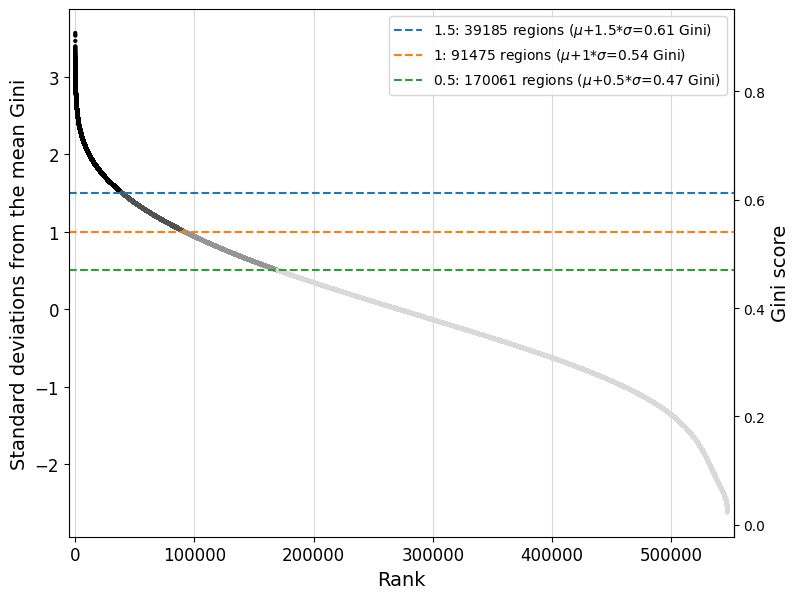

In [14]:
%matplotlib inline
crested.pl.qc.filter_cutoff(adata, cutoffs=[1.5, 1, 0.5], width=8, height=6)

The default `gini_std_threshold` of 1 seems to result in an acceptable set that's both specific and large enough to train on.

In [5]:
# All regions with a Gini index 1 std above the mean across all regions will be kept
adata_specific = crested.pp.filter_regions_on_specificity(adata, gini_std_threshold=1.0, inplace=False)
adata_specific

2026-02-15T10:31:17.660045+0100 INFO After specificity filtering, kept 91475 out of 546993 regions.


AnnData object with n_obs × n_vars = 19 × 91475
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'target_start', 'target_end', 'split'
    obsm: 'weights'

In [6]:
adata_specific.write_h5ad("crested/mouse_cortex_filtered.h5ad")

#### Load the pre-trained model and finetune with a lower learning rate

In [7]:
datamodule = crested.tl.data.AnnDataModule(
    adata_specific,
    batch_size=64,  # Recommended to go for a smaller batch size than in the base model
    max_stochastic_shift=3,
    always_reverse_complement=True,
)

In [9]:
# First load the pre-trained model
# Choose the base model with best validation loss/performance metrics
model = keras.models.load_model(
    "mouse_biccn/base_model/checkpoints/22.keras", 
    compile=False,
)

2026-02-15 10:46:54.496179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78751 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:a6:00.0, compute capability: 9.0


We use the same config we used for the pretrained model, **except for a lower learning rate**. Make sure that is lower than it was on the epoch you select the model from.

In [12]:
old_config = crested.tl.default_configs("peak_regression_count")
new_optimizer = keras.optimizers.Adam(learning_rate=1e-4)  # Lower LR!
config = crested.tl.TaskConfig(new_optimizer, old_config.loss, old_config.metrics)
print(config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x14f25098de50>, loss=CosineMSELogLoss: {'name': 'CosineMSELogLoss', 'reduction': 'sum_over_batch_size', 'max_weight': 100}, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>])


In [14]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model,
    config=config,
    project_name="mouse_biccn",  # change to your liking
    run_name="finetuned_model",  # change to your liking
    logger="wandb",  # or 'wandb', 'tensorboard'
)

In [ ]:
trainer.fit(
    epochs=60,
    learning_rate_reduce_patience=3,
    early_stopping_patience=6,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cas-blaauw. Use `wandb login --relogin` to force relogin


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 2114, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2114, 512) │     10,240 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2114, 512) │      2,048 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2114, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2114, 512) │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1conv         │ (None, 2110, 512) │    786,432 │ dropout[0][0]     │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1bn           │ (None, 2110, 512) │      2,048 │ bpnet_1conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1activation   │ (None, 2110, 512) │          0 │ bpnet_1bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1crop         │ (None, 2110, 512) │          0 │ dropout[0][0]     │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2110, 512) │          0 │ bpnet_1activatio… │
│                     │                   │            │ bpnet_1crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1dropout      │ (None, 2110, 512) │          0 │ add[0][0]         │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2conv         │ (None, 2102, 512) │    786,432 │ bpnet_1dropout[0… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2bn           │ (None, 2102, 512) │      2,048 │ bpnet_2conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2activation   │ (None, 2102, 512) │          0 │ bpnet_2bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2crop         │ (None, 2102, 512) │          0 │ bpnet_1dropout[0… │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2102, 512) │          0 │ bpnet_2activatio… │
│                     │                   │            │ bpnet_2crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2dropout      │ (None, 2102, 512) │          0 │ add_1[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,329,875 (24.15 MB)

 Trainable params: 6,320,659 (24.11 MB)

 Non-trainable params: 9,216 (36.00 KB)

None
2026-02-15T10:52:36.824223+0100 INFO Loading sequences into memory...


100%|██████████| 73326/73326 [00:06<00:00, 12111.72it/s]

2026-02-15T10:52:42.993334+0100 INFO Loading sequences into memory...



100%|██████████| 9951/9951 [00:00<00:00, 16131.93it/s]


Epoch 1/60


I0000 00:00:1771149168.283679 1051259 service.cc:145] XLA service 0x14ef7c002550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771149168.293502 1051259 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2026-02-15 10:52:50.488065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-15 10:52:53.173067: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1771149191.222934 1051259 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
wandb: ERROR Unable to log learning rate.


2292/2292 ━━━━━━━━━━━━━━━━━━━━ 258s 101ms/step - concordance_correlation_coefficient: 0.6547 - cosine_similarity: 0.8654 - loss: -0.5838 - mean_absolute_error: 1.6934 - mean_squared_error: 14.3196 - pearson_correlation: 0.7745 - pearson_correlation_log: 0.6194 - val_concordance_correlation_coefficient: 0.7122 - val_cosine_similarity: 0.8708 - val_loss: -0.6025 - val_mean_absolute_error: 1.5743 - val_mean_squared_error: 12.7560 - val_pearson_correlation: 0.7702 - val_pearson_correlation_log: 0.6352 - learning_rate: 1.0000e-04
Epoch 2/60
2292/2292 ━━━━━━━━━━━━━━━━━━━━ 213s 93ms/step - concordance_correlation_coefficient: 0.6999 - cosine_similarity: 0.8795 - loss: -0.6249 - mean_absolute_error: 1.5950 - mean_squared_error: 12.9309 - pearson_correlation: 0.7975 - pearson_correlation_log: 0.6386 - val_concordance_correlation_coefficient: 0.7245 - val_cosine_similarity: 0.8718 - val_loss: -0.6067 - val_mean_absolute_error: 1.5692 - val_mean_squared_error: 12.5116 - val_pearson_correlation: 0

## Evaluate the model
Now we have a trained model, we can use the `crested.tl` toolkit to run inference and explain our results. All the functionality shown below only expects a trained .keras model, meaning that you can use these functions with any model trained outside of the CREsted framework too.

First, we need to load a model. If you followed the tutorial, you can load that one.  
If not, CREsted has a 'model repository' with commonly used models which you can download with 
{func}`~crested.get_model`. You can find all example models [here](/models/index).

In [5]:
# Reload your data if it's not the same session
adata = ad.read_h5ad("crested/mouse_cortex.h5ad")
adata_specific = ad.read_h5ad("crested/mouse_cortex_filtered.h5ad")

In [6]:
# Load your trained model, at its best (validation) epoch
model_path_base = "mouse_biccn/base_model/checkpoints/22.keras"
model_path_ft = "mouse_biccn/finetuned_model/checkpoints/02.keras"

model_base = keras.models.load_model(model_path_base, compile=False)
model = keras.models.load_model(model_path_ft, compile=False)

2026-02-16 13:09:02.517841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78751 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:26:00.0, compute capability: 9.0


### Predict

{func}`~crested.tl.predict` is CREsted's swiss army knife: it lets you use the model to predict inputs in any form.  
Since CREsted is build around making predictions over genomic sequences, this can accept as input:
- (lists of) sequence(s)
- (lists of) genomic region name(s)
- one hot encoded sequences of shape (N, L, 4)
- AnnData objects with regions as its .var index

CREsted will convert these inputs to its required format for the model.  
If your input is a region name or AnnData, you should provide a genome as well if you did not register one.  
You can even provide a list of models, as long as they expect the same input and output shapes. In that case the predictions will be averaged, which can be useful to make your predictions more robust. 

:::{note}  
Due to issues in `keras`'s prediction functionality, running this for the entire AnnData can use a large amount of memory. If this is a bottleneck, we recommend running this once or in chunks, saving the AnnData with the prediction layers, and restarting the analysis from there.
:::  

Almost all plotting functions recognise predictions saved in the `adata.layers` slot, so we'll be predicting all specific regions and saving the resulting predictions:

In [7]:
predictions_base = crested.tl.predict(adata_specific, model_base)
adata_specific.layers["Base model"] = predictions_base.T  # adata expects (classes, genes) instead of (genes, classes)
predictions_ft = crested.tl.predict(adata_specific, model)
adata_specific.layers["Finetuned model"] = predictions_ft.T

2026-02-16T13:09:03.967768+0100 INFO Lazily importing module crested.tl. This could take a second...


I0000 00:00:1771243808.872116 2286658 service.cc:145] XLA service 0x15402c00d660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771243808.880903 2286658 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2026-02-16 13:10:09.660368: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-16 13:10:10.247383: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


  5/715 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step

I0000 00:00:1771243816.149309 2286658 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


713/715 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

I0000 00:00:1771243836.149019 2287044 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 4 bytes spill stores, 4 bytes spill loads



715/715 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step
715/715 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step


Many of the plotting functions in the `crested.pl` module can be used to visualize these model predictions.  

### Evaluating on the test set

Let's first look at the performance on the test set using the {func}`~crested.tl.evaluate` function:

In [8]:
crested.tl.evaluate(
    adata_specific,
    model='Finetuned model',
    metrics=crested.tl.default_configs('peak_regression_count')
)

2026-02-16T13:11:06.247458+0100 INFO Test CosineMSELogLoss: -0.6362
2026-02-16T13:11:06.248170+0100 INFO Test mean_absolute_error: 1.6739
2026-02-16T13:11:06.248430+0100 INFO Test mean_squared_error: 14.3069
2026-02-16T13:11:06.248631+0100 INFO Test cosine_similarity: 0.8715
2026-02-16T13:11:06.248820+0100 INFO Test pearson_correlation: 0.7809
2026-02-16T13:11:06.249006+0100 INFO Test concordance_correlation_coefficient: 0.7308
2026-02-16T13:11:06.249197+0100 INFO Test pearson_correlation_log: 0.6371


If you experimented with many different hyperparameters for your model, chances are that you will start overfitting on your validation dataset.  
It's therefore always a good idea to evaluate your model on the test set after getting good results on your validation data to see how well it generalizes to unseen data.

#### Example predictions on test set regions

It is always interesting to see how the model performs on unseen test set regions. It is recommended to always look at a few examples to spot potential biases, or trends that you do not expect.

In [9]:
# Define a dataframe with test set regions
test_df = adata_specific.var[adata_specific.var["split"] == "test"]
test_df

chr      start        end  target_start  \
region                                                                
chr18:3269690-3271804     chr18    3269690    3271804       3270247   
chr18:3350307-3352421     chr18    3350307    3352421       3350864   
chr18:3451398-3453512     chr18    3451398    3453512       3451955   
chr18:3463977-3466091     chr18    3463977    3466091       3464534   
chr18:3488308-3490422     chr18    3488308    3490422       3488865   
...                         ...        ...        ...           ...   
chr9:124125533-124127647   chr9  124125533  124127647     124126090   
chr9:124140961-124143075   chr9  124140961  124143075     124141518   
chr9:124142793-124144907   chr9  124142793  124144907     124143350   
chr9:124477280-124479394   chr9  124477280  124479394     124477837   
chr9:124479548-124481662   chr9  124479548  124481662     124480105   

                          target_end split  
region                                      
chr18:3269690-3271804        3271247  test  
chr18:3350307-3352421        3351864  test  
chr18:3451398-3453512        3452955  test  
chr18:3463977-3466091        3465534  test  
chr18:3488308-3490422        3489865  test  
...                              ...   ...  
chr9:124125533-124127647   124127090  test  
chr9:124140961-124143075   124142518  test  
chr9:124142793-124144907   124144350  test  
chr9:124477280-124479394   124478837  test  
chr9:124479548-124481662   124481105  test  

[8198 rows x 6 columns]

chr18:3892771-3894885
2026-02-16T13:11:07.047437+0100 INFO Lazily importing module crested.pl. This could take a second...


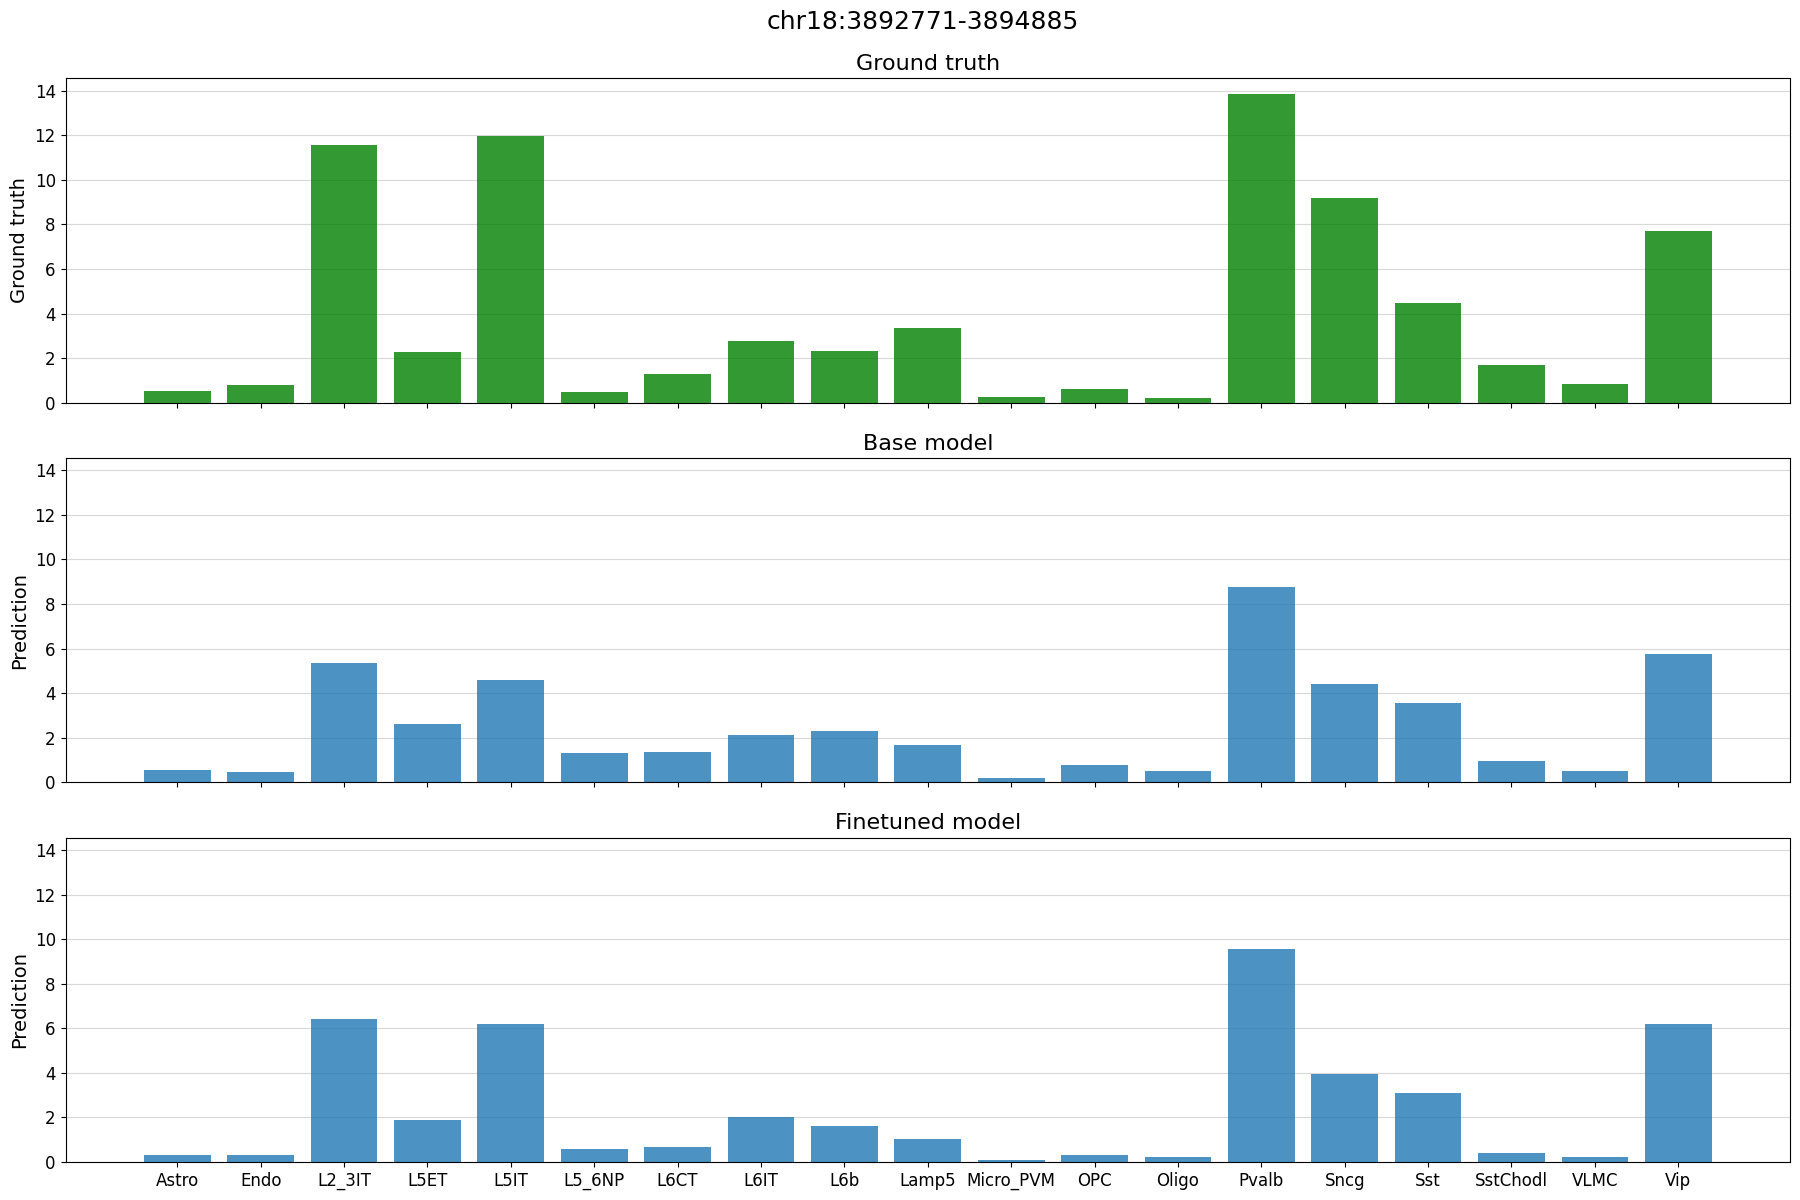

In [10]:
%matplotlib inline
# plot predictions vs ground truth for a random region in the test set defined by index
idx = 21
region = test_df.index[idx]
print(region)
crested.pl.region.bar(adata_specific, region)

##### Example predictions on manually defined regions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


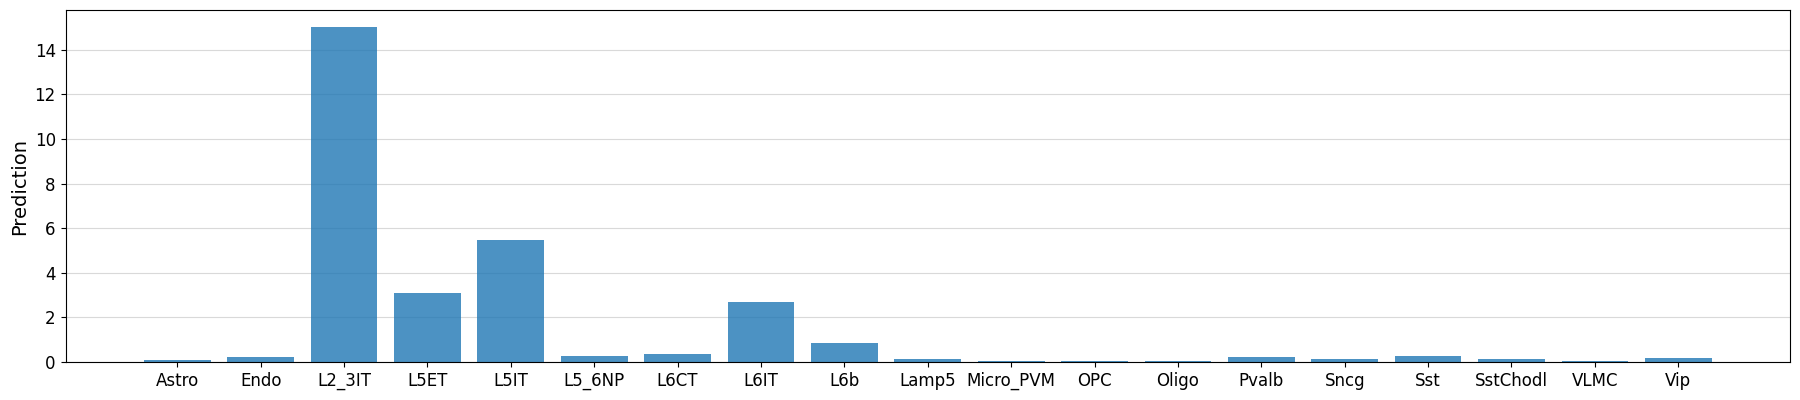

In [11]:
# Could also manually fetch and pass sequence with genome.fetch(chrom, start, end)
prediction = crested.tl.predict("chr3:72535071-72537185", model)

crested.pl.region.bar(prediction, classes=list(adata_specific.obs_names))

#### Model performance on the entire test set

After looking at specific instances, now we can look at the model performance on a larger scale.

First, we can check compare the predictions vs ground truth in a scatterplot for all regions in a class:

2026-02-16T13:11:13.759705+0100 INFO Plotting density scatter for class: L2_3IT, models: ['Finetuned model'], split: test


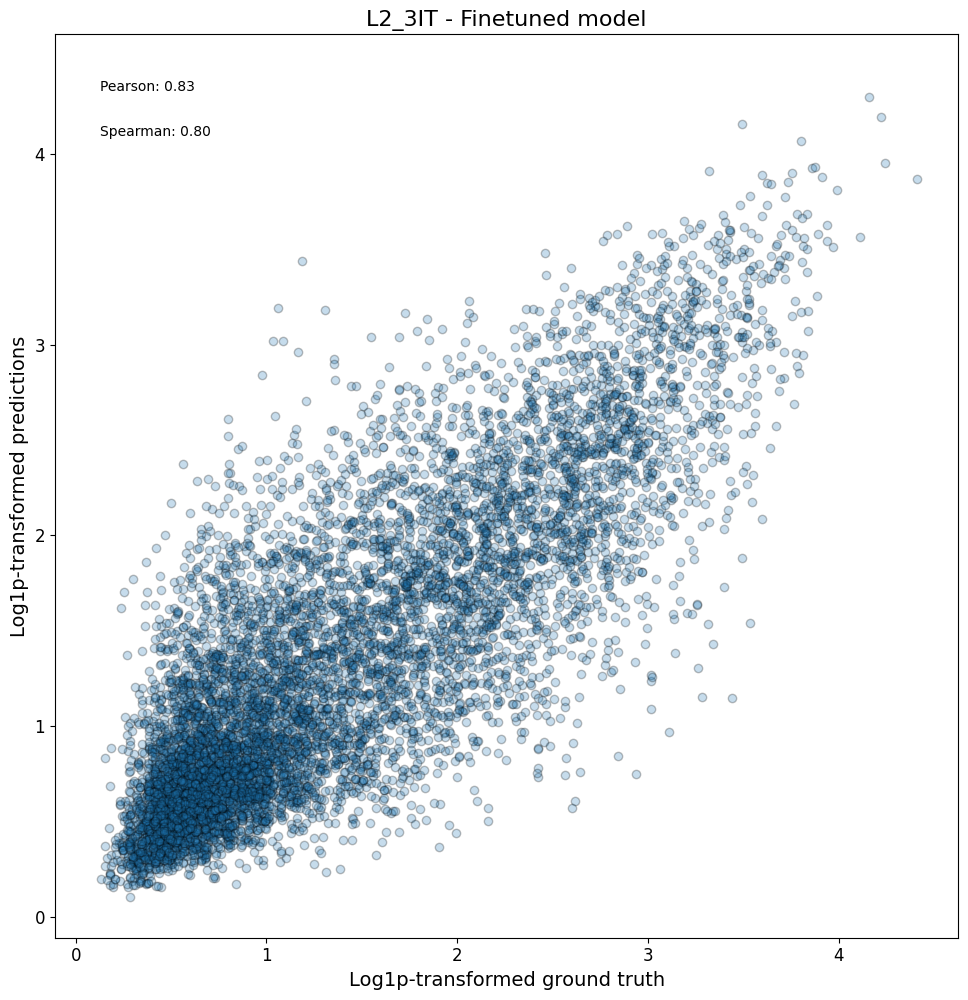

In [12]:
crested.pl.corr.scatter(
    adata_specific,
    class_name="L2_3IT",
    model_names="Finetuned model",
    split="test",
    log_transform=True,
    square=True,
    width=10,
    height=10,
)

Or even all classes at once, and/or comparing across models:

2026-02-16T13:11:14.081321+0100 INFO Plotting density scatter for all targets and predictions, models: ['Base model', 'Finetuned model'], split: test


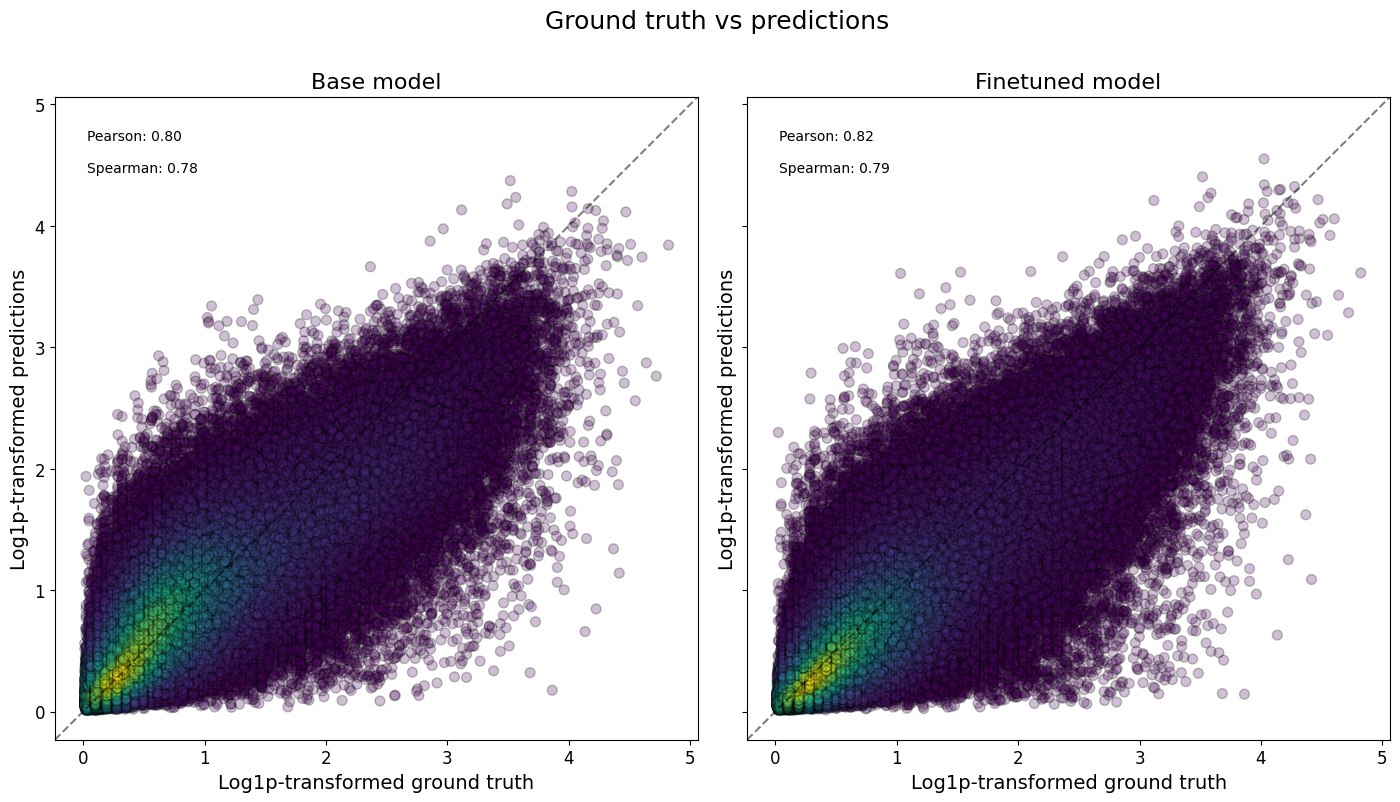

In [13]:
crested.pl.corr.scatter(
    adata_specific,
    split="test",
    log_transform=True,
    density_indication=True,
    identity_line=True,
    square=True,
)

To now check the correlations between all classes, we can plot a heatmap to assess the model performance.

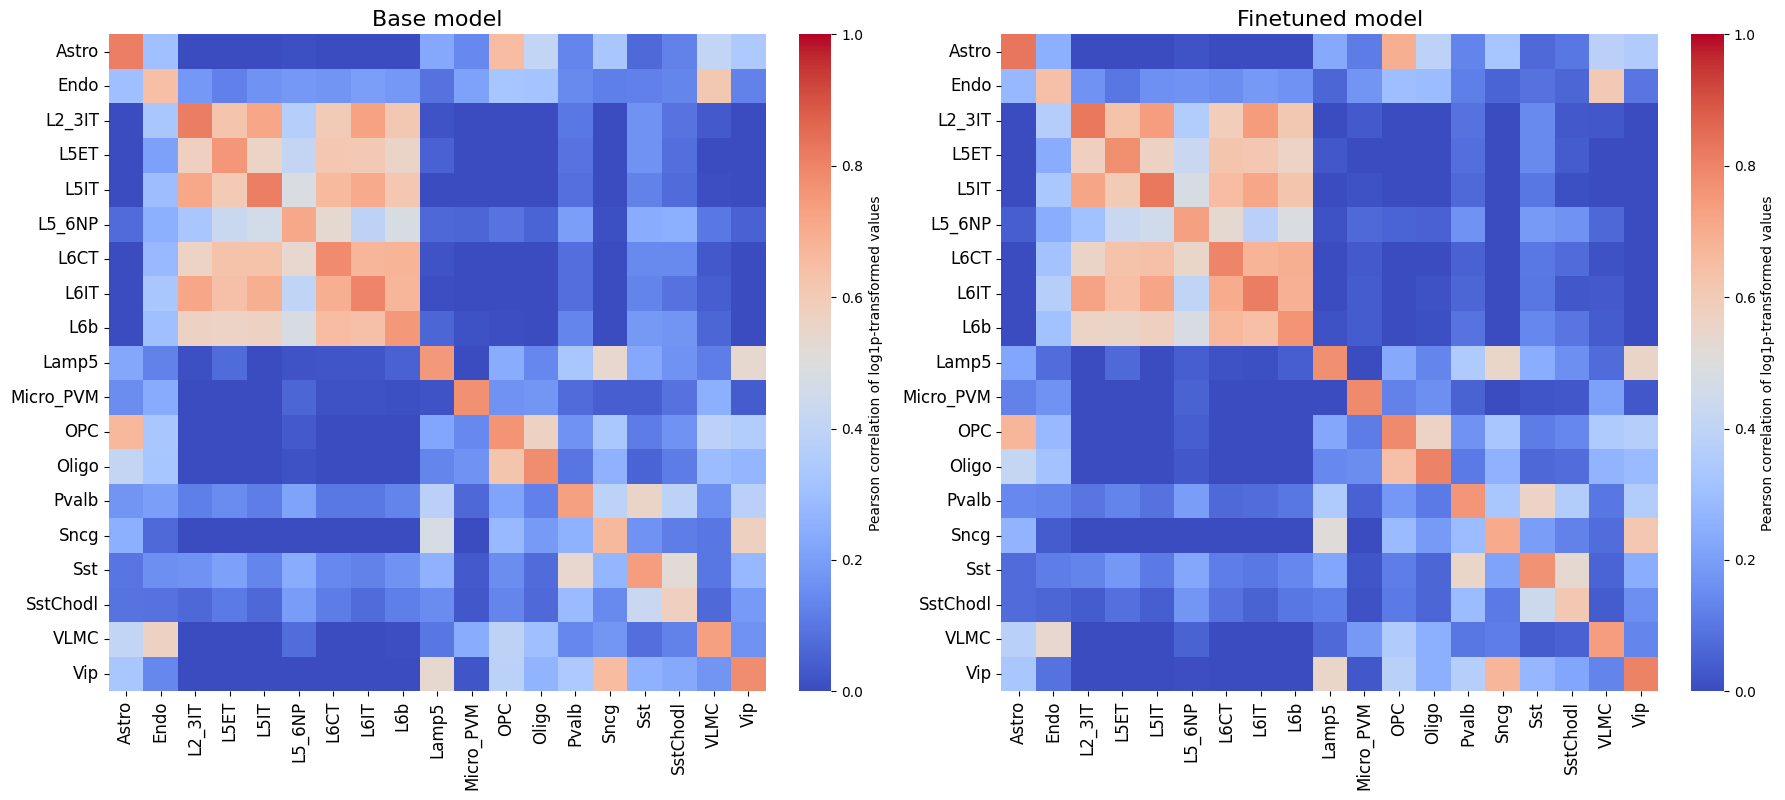

In [14]:
crested.pl.corr.heatmap(
    adata_specific,
    split="test",
    log_transform=True,
    vmax=1,
    vmin=0,
)

It is also recommended to compare this heatmap to the self-correlation plot of the peaks themselves. If peaks between cell types are correlated, then it is expected that predictions from non-matching classes for correlating cell types will also be high, even if the predictions are perfect.

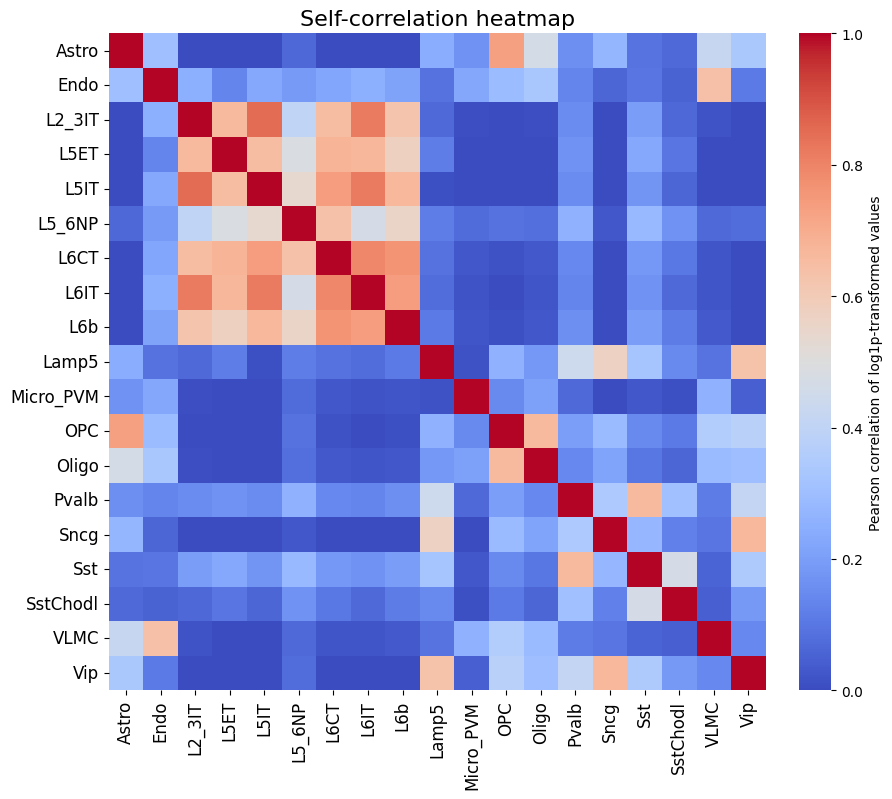

In [15]:
crested.pl.corr.heatmap_self(
    adata_specific,
    xtick_rotation=90,
    log_transform=True,
    title="Self-correlation heatmap",
    vmax=1,
    vmin=0,
)

To better compare different models, we can also specifically compare the correlations for each class with their own ground truths (which are shown on the diagonal in the heatmaps). One way is through a violin plot:

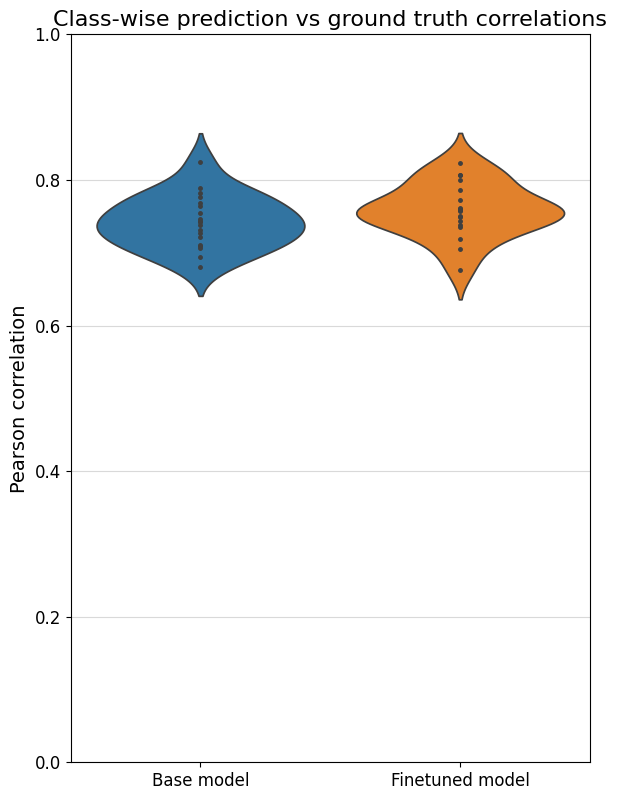

In [16]:
%matplotlib inline
crested.pl.corr.violin(adata_specific)

### Sequence contribution scores

We can calculate the contribution scores for a **sequence** of interest using the {func}`~crested.tl.contribution_scores` function.  

This will give us information on what nucleotides the model is looking at to make its prediction with respect to a specific output class. 

You always need to ensure that the sequence or region you provide is the same length as the model input (2114bp in our case).  

Here, similar to the `predict` function, you need some input (like a sequence or region name) and a (list of) model(s). If multiple models are provided, the contribution scores will be averaged.

#### Contribution scores on manually defined genomic regions

In [17]:
# similar example but with region names as input
regions_of_interest = "chr18:61107770-61109884"  # FIRE enhancer region (Microglia enhancer)
classes_of_interest = ["Astro", "Micro_PVM"]
class_idx = list(adata_specific.obs_names.get_indexer(classes_of_interest))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    regions_of_interest,
    target_idx=class_idx,
    model=model,
    method="integrated_grad", # recommended. Other options: "expected_integrated_grad" (default), "saliency_map", "mutagenesis", "window_shuffle"
)

2026-02-16T13:11:22.646080+0100 INFO Calculating contribution scores for 2 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Contribution scores for regions can be plotted using the {func}`crested.pl.explain.contribution_scores` function.  
This will generate a subplot per region, per class.

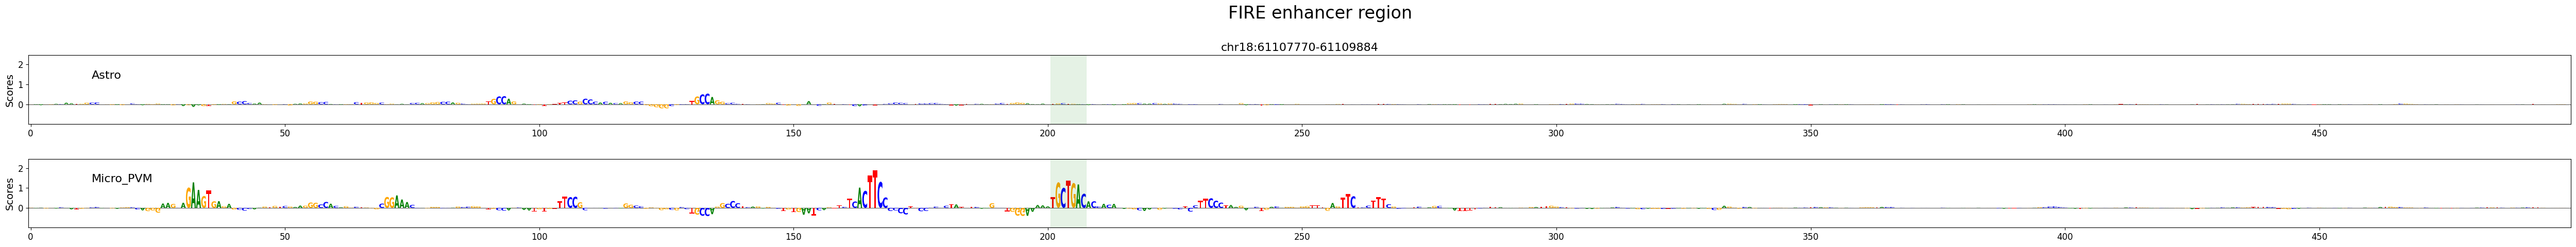

In [18]:
%matplotlib inline
crested.pl.explain.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=regions_of_interest,
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    suptitle="FIRE enhancer region",
    suptitle_fontsize=24,
    highlight_positions=(1008, 1014),  # starts counting from start of region, not from zoom
    highlight_kws={'facecolor': 'green', 'edgecolor': 'green', 'alpha': 0.1},
)

#### Contribution scores on random test set regions

In [19]:
# plot predictions vs ground truth for a random region in the test set defined by index
idx = 21
region = test_df.index[idx]
classes_of_interest = ["L2_3IT", "Pvalb"]
class_idx = list(adata_specific.obs_names.get_indexer(classes_of_interest))
scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    region,
    target_idx=class_idx,
    model=model,
    method='integrated_grad',
)

2026-02-16T13:11:29.056850+0100 INFO Calculating contribution scores for 2 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


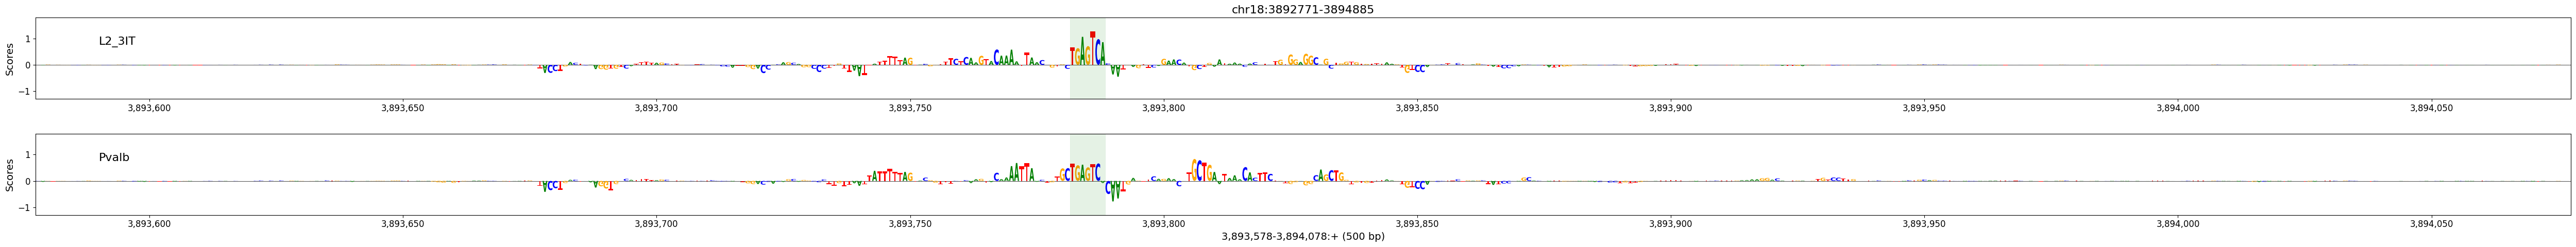

In [20]:
crested.pl.explain.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=region,
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    coordinates=region,
    highlight_positions=(3893782, 3893788),
    highlight_kws={'facecolor': 'green', 'edgecolor': 'green', 'alpha': 0.1}
)

#### Prediction on gene locus

We can also score a gene locus by using a sliding window over a predefined genomic range. We can then compare those predictions to the bigWig of the cell type where we got our peak scores from, to see if the CREsted predictions match the measured data. 

In [21]:
chrom = "chr18"  # Unseen chromosome
start = 59175401
end = 59410446

cell_type = "L6CT"
class_idx = list(adata_specific.obs_names).index(cell_type)

upstream = 50000
downstream = 25000

strand = "+"

scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    model=model,
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step


In [22]:
bigwig = os.path.join(bigwigs_folder, f"{cell_type}.bw")

values = (
    crested.utils.read_bigwig_region(bigwig, (chrom, start - upstream, end + downstream))
    if strand == "+"
    else crested.utils.read_bigwig_region(bigwig, (chrom, start - downstream, end + upstream))
)
bw_values = values[0]
midpoints = values[1]

Note that here we compared pooled predictions over 1kb regions and cut-sites at 1 bp resolution from a cut-sites BigWig. To get a better comparison between the predicted and scATAC track, we recommend to compare against a coverage BigWig.

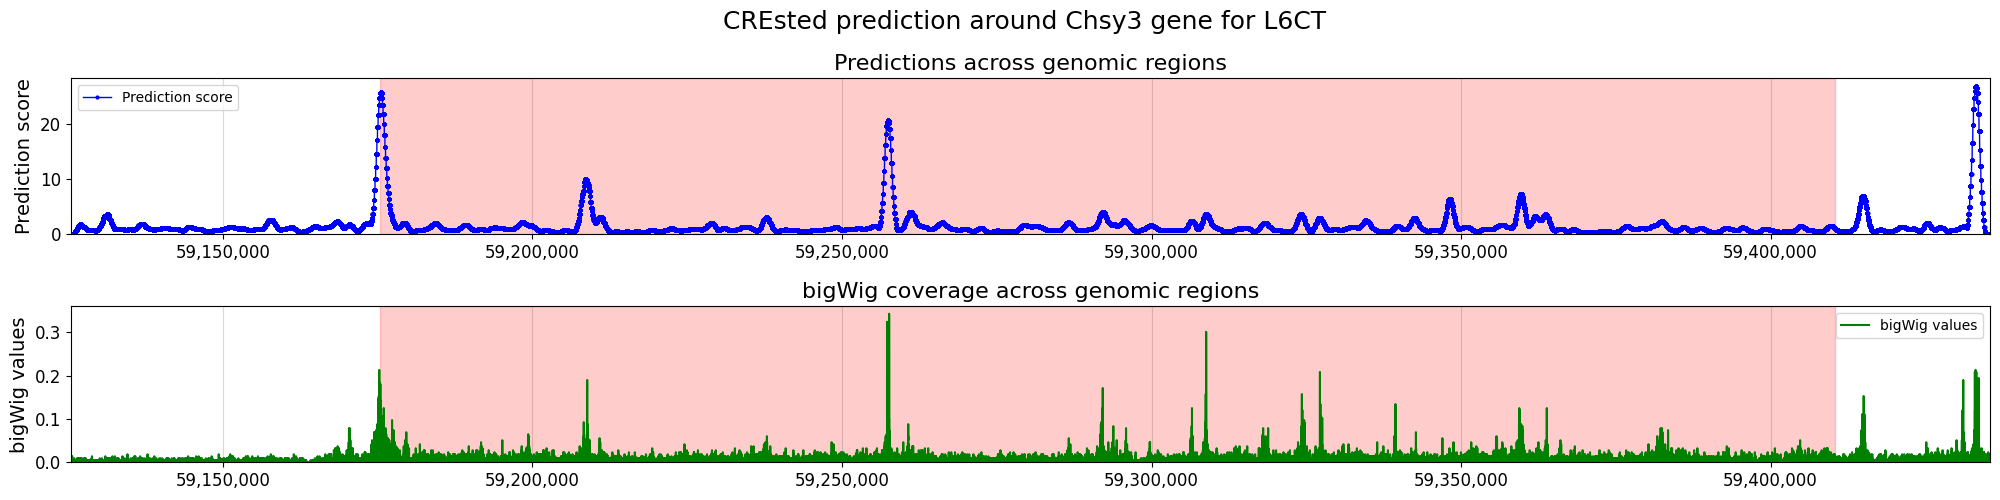

In [23]:
%matplotlib inline
crested.pl.locus.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    suptitle="CREsted prediction around Chsy3 gene for " + cell_type,
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
    grid='x',
    width=20,
    height=5,
    locus_plot_kws={'markersize': 2, 'linewidth': 1},
)

## Enhancer design

Enhancer design is an important concept in understanding a cell type's cis-regulatory code.  
By designing sequences to be specifically accessible for a cell type and inspecting those designed sequences' contribution score plots, we can get an understanding of which motifs are most important for that cell type's enhancer code. Moreover, by inspecting intermediate results throughout the optimization process, we can see which motifs and which motif positions have a comparatively higher priority.

We follow the enhancer design process as described [in this paper](https://www.nature.com/articles/s41586-023-06936-2) (Taskiran et al., Nature, 2024). We start from random sequences and select at each step the nucleotide mutation or motif implementation that will lead to the largest change in specific accessibility for a chosen cell type.

### Sequence evolution

The standard way of designing enhancers (by making single nucleotide mutations in randomly generated regions) can be carried out using {func}`~crested.tl.design.in_silico_evolution`.

Before we start designing, we will calculate the nucleotide distribution of our consensus regions, which will be used for creating random starting sequences. If you don't do this, the design function will assume a uniform distribution.

In [24]:
acgt_distribution = crested.utils.calculate_nucleotide_distribution(
    adata_specific,  # accepts any sequence input, same as before
    per_position=True,  # return a distirbution per position in the sequence
)
acgt_distribution.shape

(2114, 4)

In [25]:
# we will design an enhancer for the L5ET cell type
class_idx = list(adata_specific.obs_names).index("L5ET")

intermediate_results, designed_sequences = crested.tl.design.in_silico_evolution(
    model=model,
    target=class_idx,  # the default optimization function expects a target class index
    n_mutations=10,    # n single nucleotide mutations to make per sequence
    n_sequences=2,     # n enhancers to design
    target_len=500,    # only make mutations in the center 500bp
    acgt_distribution=acgt_distribution,  # if None, uniform distribution will be used
    return_intermediate=True, # allows inspection of improvements at every step
)

100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


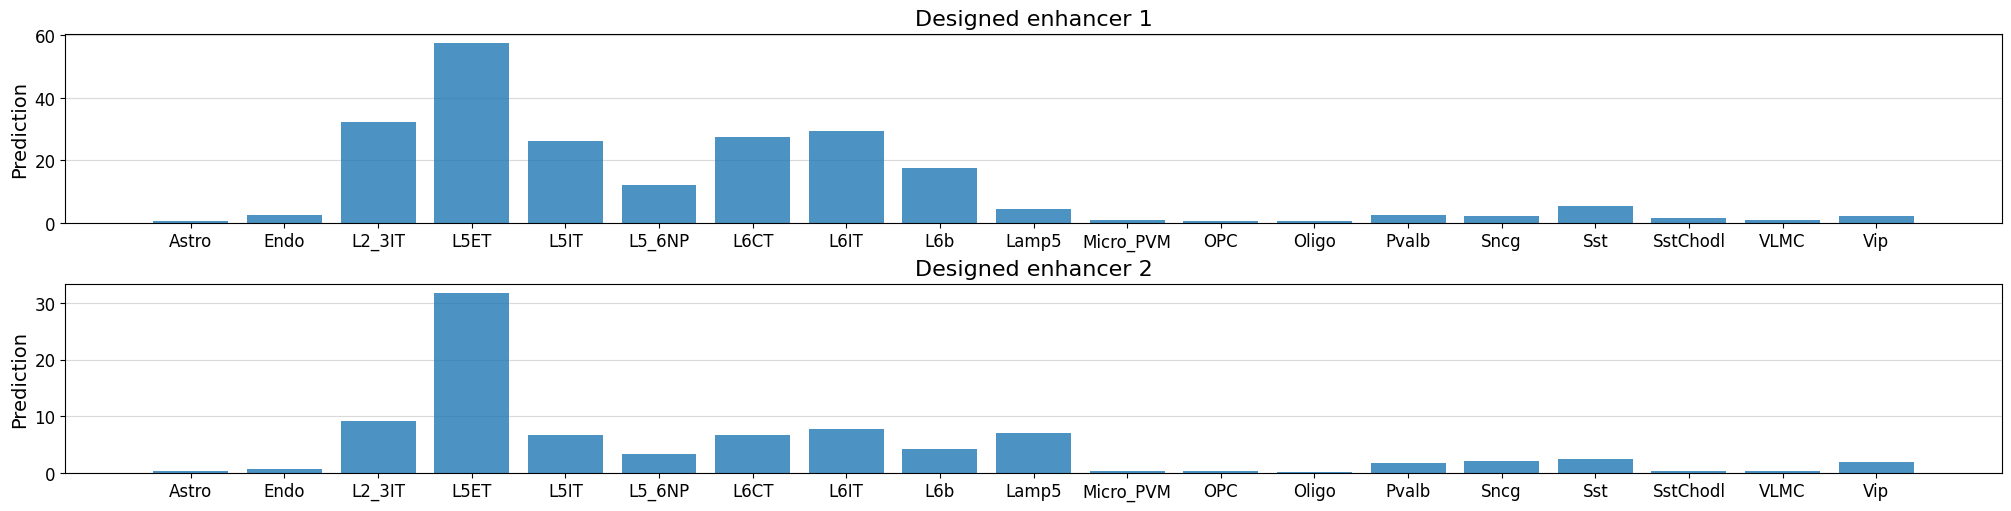

In [26]:
%matplotlib inline
# Check predictions for the designed sequences - ensure that they're high for our target class
fig, axs = plt.subplots(2, figsize = (20, 5), layout='constrained')

for i in range(len(designed_sequences)):
    prediction = crested.tl.predict(designed_sequences[i], model=model)
    crested.pl.region.bar(prediction, classes=list(adata_specific.obs_names), title=f"Designed enhancer {i+1}", ax=axs[i], show=False)

In [27]:
# Calculate contribution scores for the designed sequences
scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    designed_sequences,
    model=model,
    target_idx=class_idx,
)

2026-02-16T13:11:55.718144+0100 INFO Calculating contribution scores for 1 class(es) and 2 region(s).


Model: 100%|██████████| 1/1 [00:05<00:00,  5.16s/it]


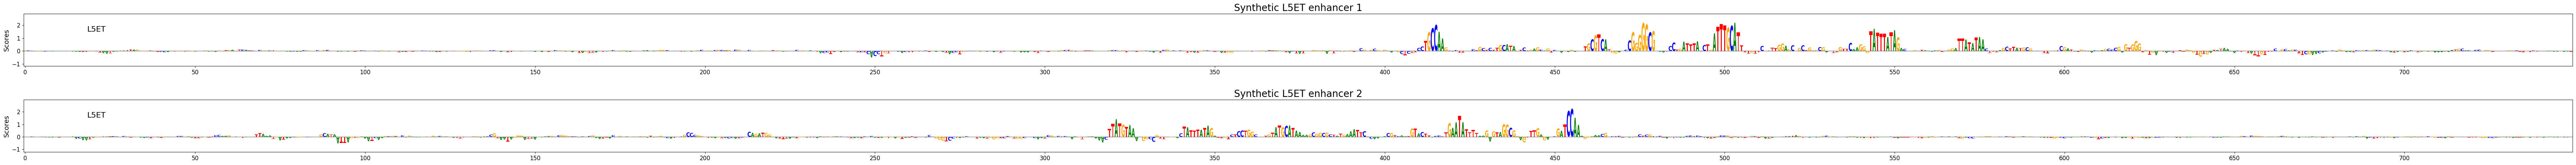

In [28]:
crested.pl.explain.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=["Synthetic L5ET enhancer 1", "Synthetic L5ET enhancer 2"],
    title_fontsize=20,
    class_labels="L5ET",
    zoom_n_bases=750,
)

Keep in mind that, if you start from random sequences, enhancer design will be non-deterministic so you won't get the exact same results twice.

### Inspecting the enhancer design process

Thanks to the handy *return_intermediate* parameter, we can inspect at which point in the process which mutations are made. We can use some specialized plotting functions to visualize this process. Let's first look at the predictions:

In [29]:
print(intermediate_results[0].keys())

dict_keys(['initial_sequence', 'changes', 'predictions', 'designed_sequence'])


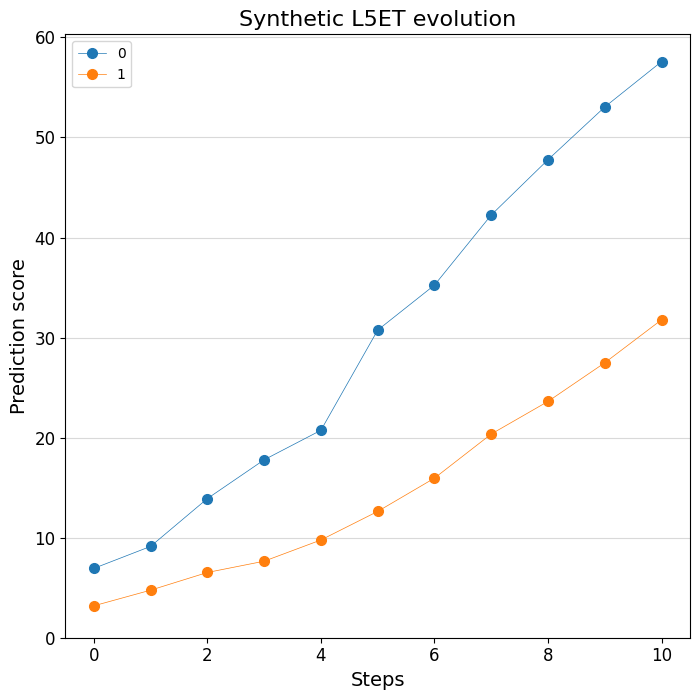

In [30]:
# Plot the change of predictions along the design process
%matplotlib inline
crested.pl.design.step_predictions(
    intermediate_results,
    target_classes="L5ET",
    obs_names=adata_specific.obs_names,
    separate=True,
    legend_separate=True,
    title="Synthetic L5ET evolution",
    width=7,
    height=7,
)


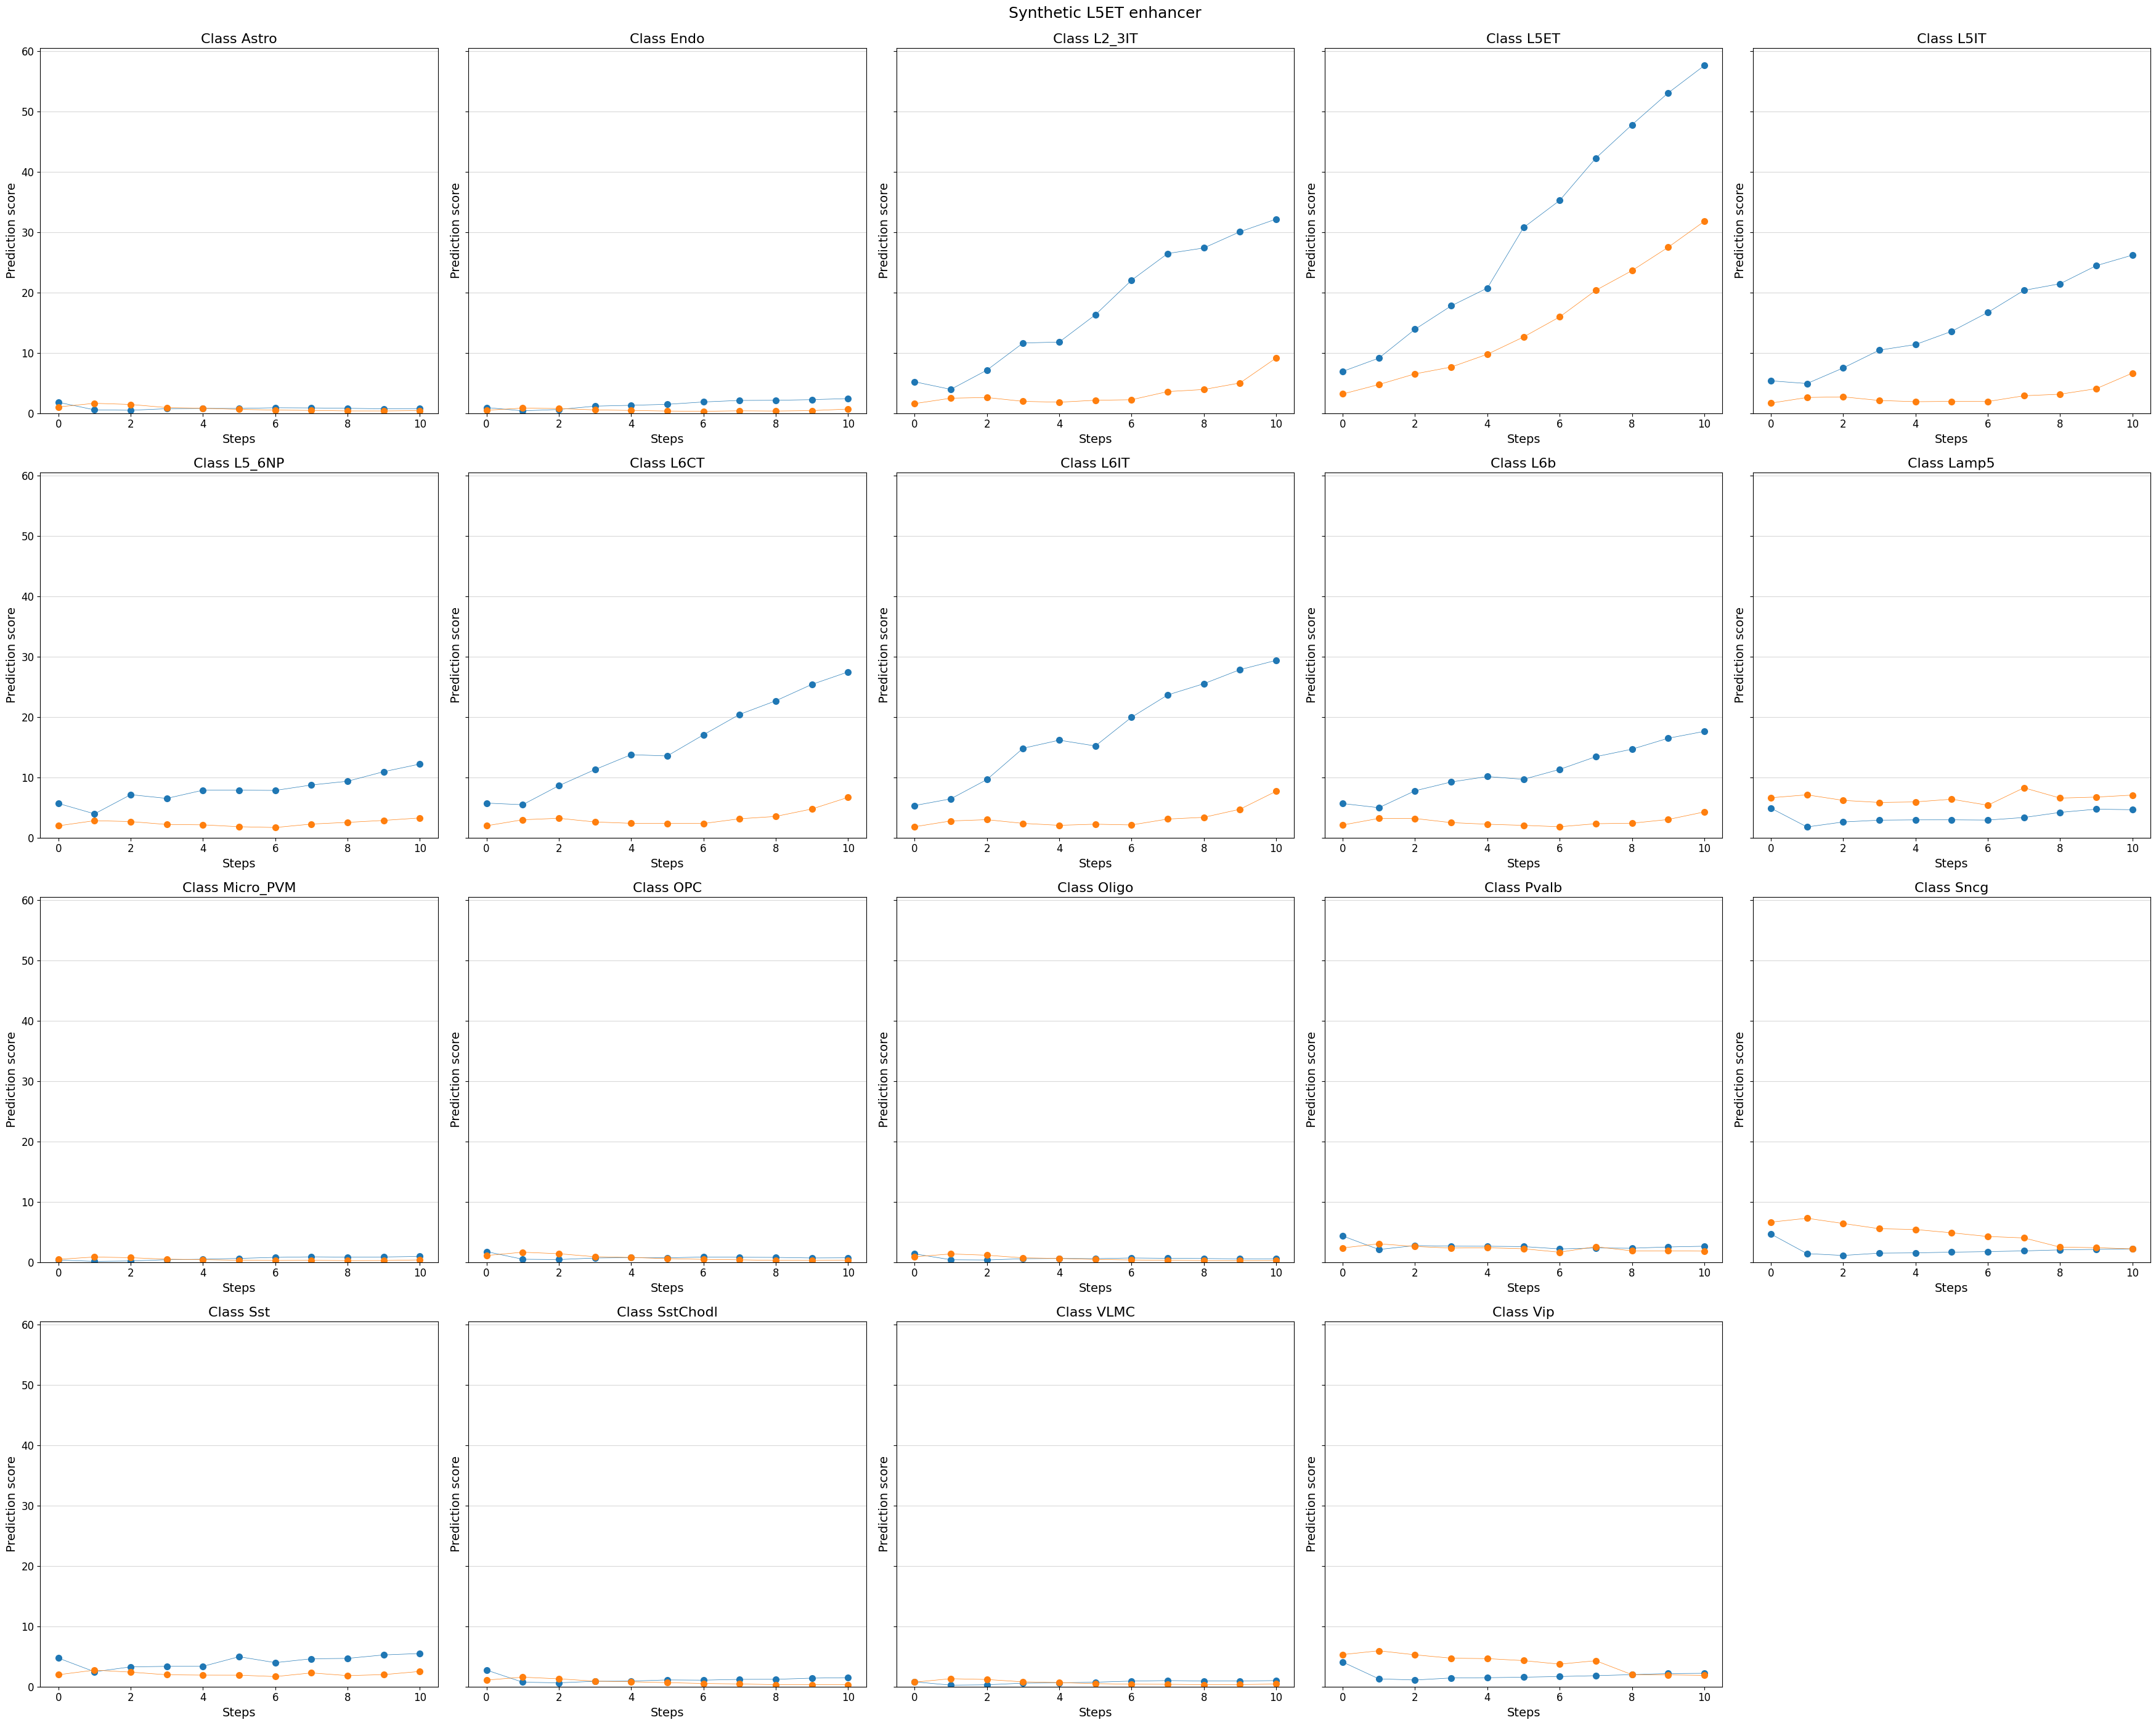

In [31]:
# You can even visualize other (off-target) classes, or all classes
%matplotlib inline
crested.pl.design.step_predictions(
    intermediate_results,
    target_classes=adata_specific.obs_names,
    obs_names=adata_specific.obs_names,
    separate=True,
    suptitle="Synthetic L5ET enhancer",
)

We can also look at the contribution scores for every step in the evolution:

In [32]:
# There's a utility function to extract the intermediate sequences from the dict
intermed_seqs = crested.tl.design.derive_intermediate_sequences(intermediate_results)

# With which we can calculate contribution scores as usual:
scores_all = []
seqs_one_hot_all = []
for seq_idx in range(len(intermed_seqs)):
    scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
        intermed_seqs[seq_idx],
        target_idx=class_idx,
        model=model,
    )
    scores_all.append(scores)
    seqs_one_hot_all.append(one_hot_encoded_sequences)

2026-02-16T13:12:08.395529+0100 INFO Calculating contribution scores for 1 class(es) and 11 region(s).


Model: 100%|██████████| 1/1 [00:10<00:00, 10.33s/it]

2026-02-16T13:12:18.724980+0100 INFO Calculating contribution scores for 1 class(es) and 11 region(s).



Model: 100%|██████████| 1/1 [00:10<00:00, 10.34s/it]


{func}`crested.pl.design.step_contribution_scores` shows the change locations, and supports multiple designed sequences.
You can also use standard plotting to visualize the scores, of course.

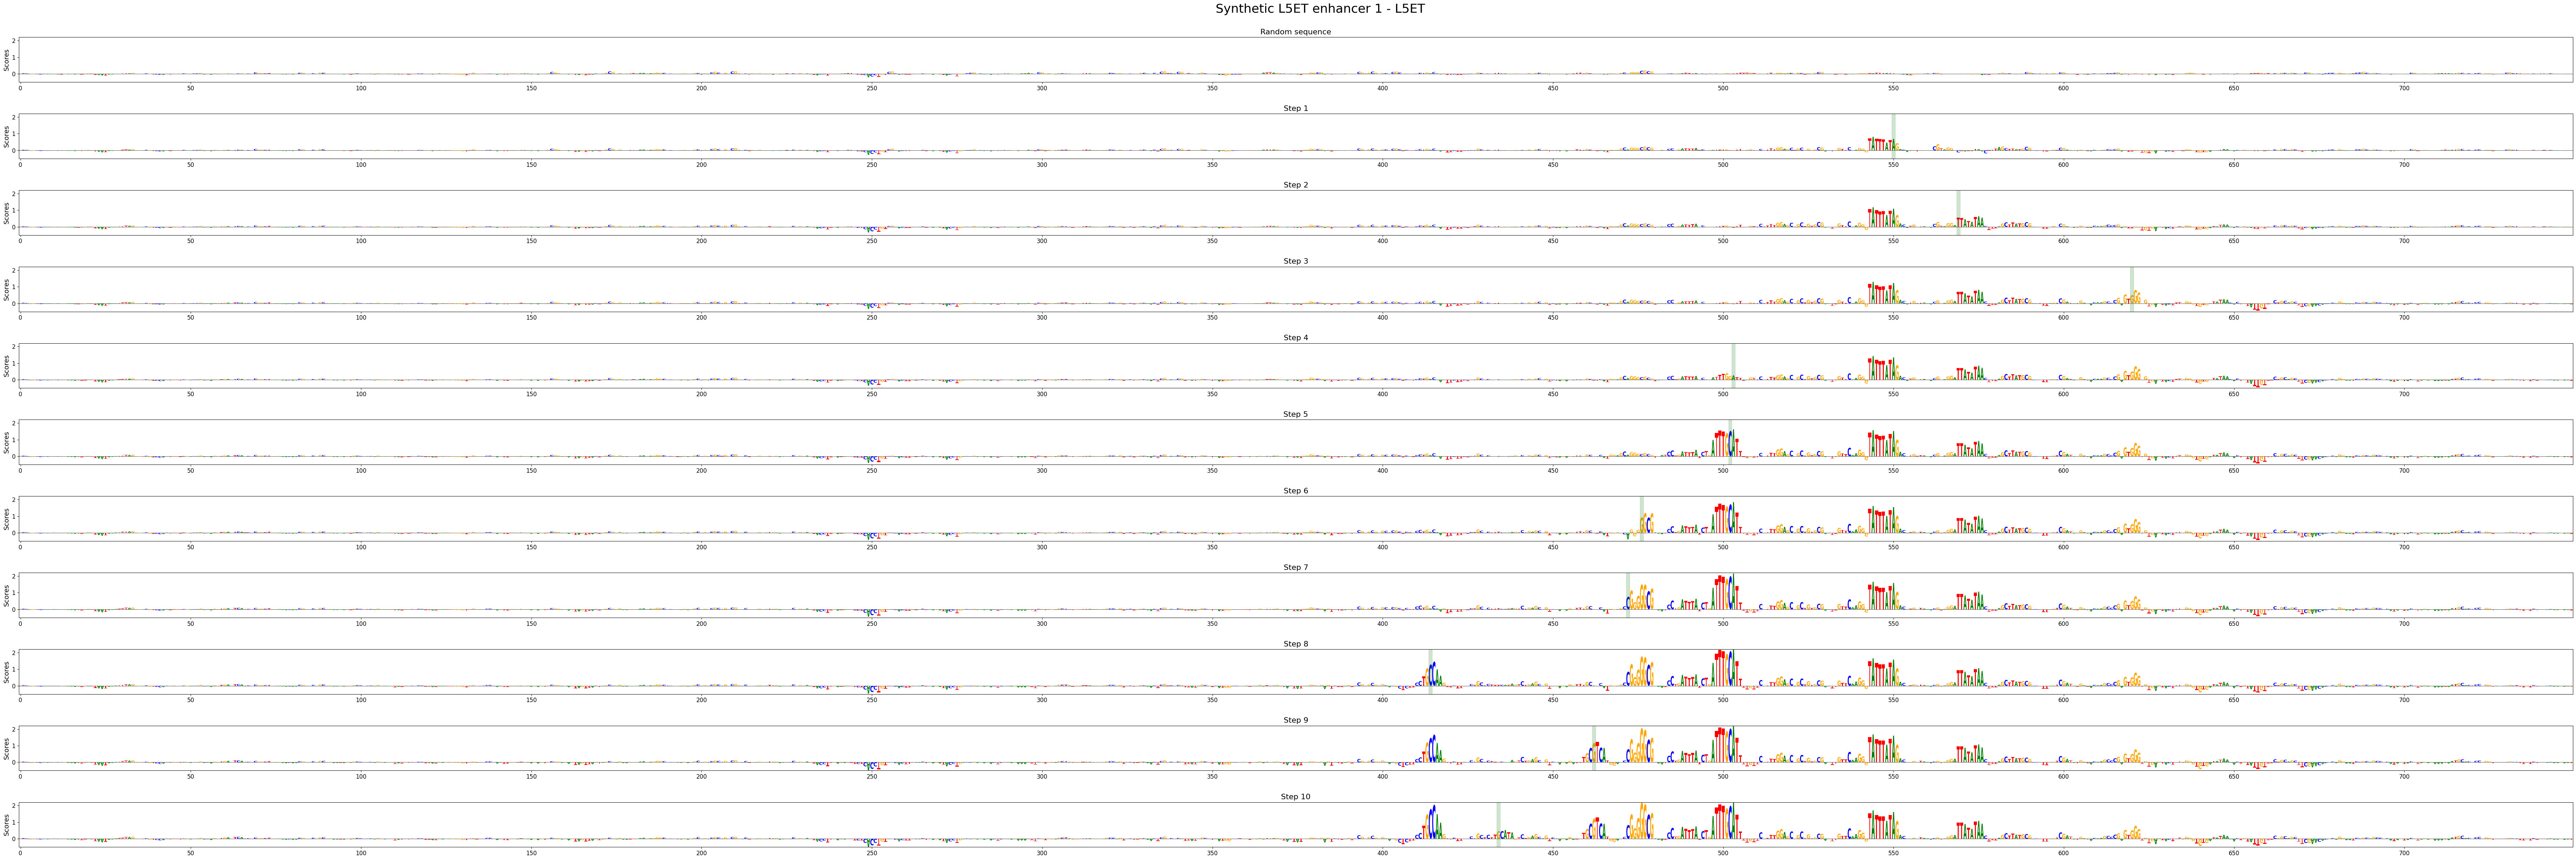

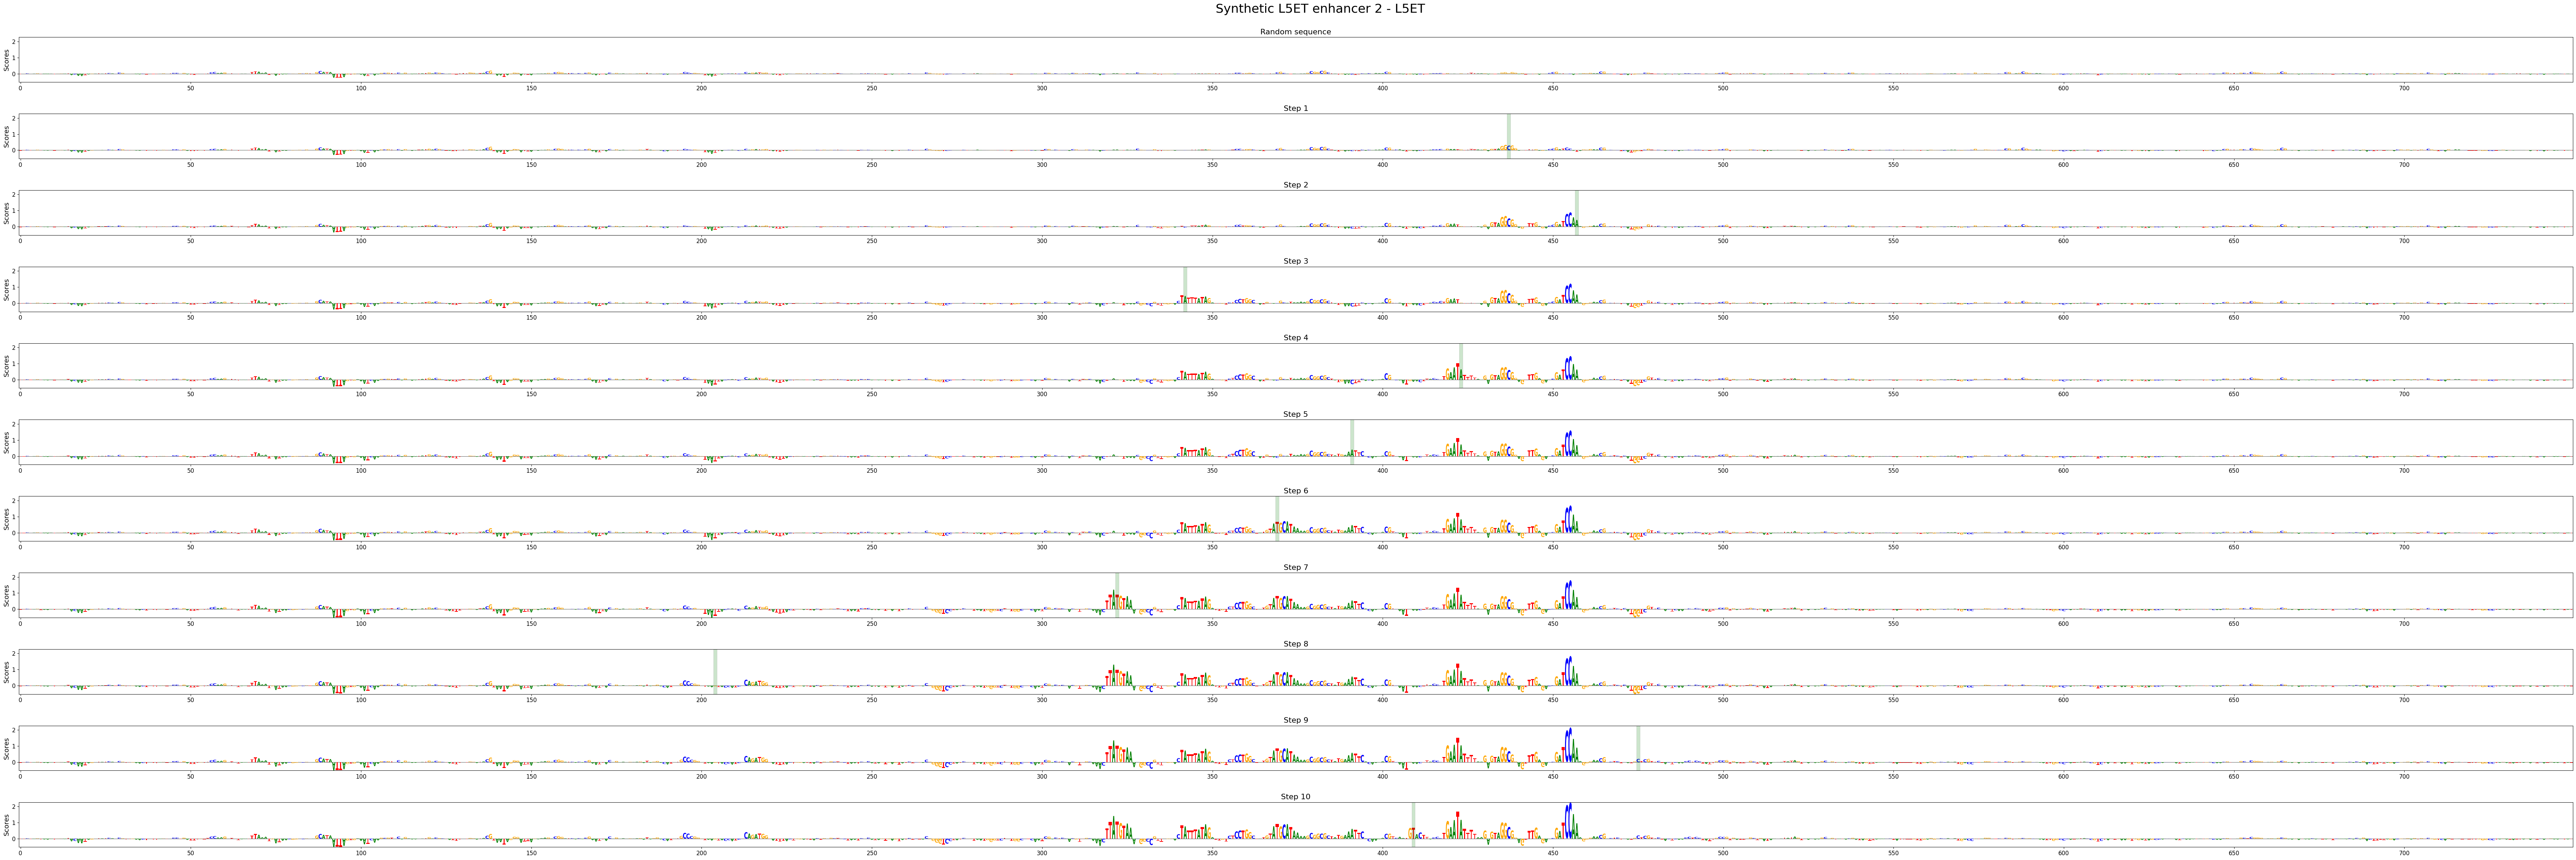

In [33]:
crested.pl.design.step_contribution_scores(
    intermediate_results,
    scores_all=scores_all,
    seqs_one_hot_all=seqs_one_hot_all,
    zoom_n_bases=750,
    sequence_labels=["Synthetic L5ET enhancer 1", "Synthetic L5ET enhancer 2"],
    class_labels="L5ET",
    highlight_kws={"facecolor": "green", "edgecolor": "black", "alpha": 0.2}
)

### Motif insertion

Another way of designing enhancers is by embedding known motifs into our sequences.  
This way, you can investigate how specific motif combinations influence a sequence's accessibility profile.
For this, you can use the {meth}`crested.tl.design.motif_insertion` function. We can use the intermediate results to highlight the inserted motifs.

In [34]:
class_idx = list(adata_specific.obs_names).index("Oligo")

intermediate_results, designed_sequences = crested.tl.design.motif_insertion(
    patterns={
        "SOX10": "AACAATGGCCCCATTGT",
        "CREB5": "ATGACATCA",
    },
    target=class_idx,
    model=model,
    acgt_distribution=acgt_distribution,
    n_sequences=2,
    target_len=500,
    return_intermediate=True,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


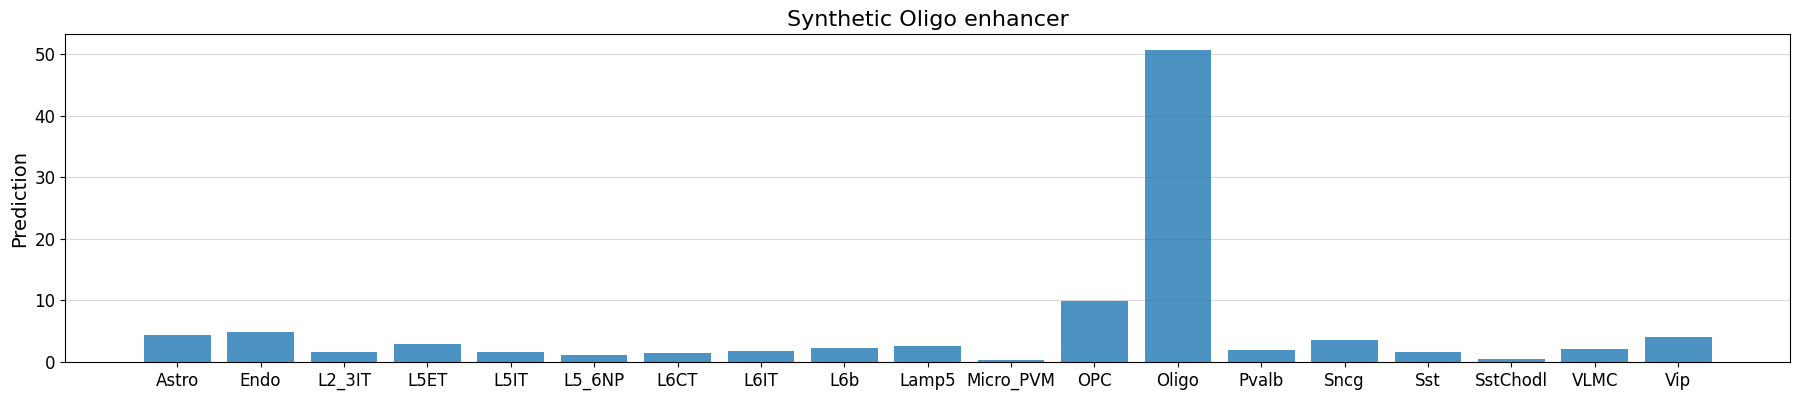

In [35]:
seq_idx = 0

# check whether our implanted motifs have the expected effect
prediction = crested.tl.predict(designed_sequences, model=model)
crested.pl.region.bar(
    prediction[seq_idx],
    classes=list(adata_specific.obs_names),
    title="Synthetic Oligo enhancer",
)

In [36]:
intermediate_results[0]["changes"]

[(-1, 'N'), (1017, 'AACAATGGCCCCATTGT'), (998, 'ATGACATCA')]

In [37]:
scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    designed_sequences[seq_idx],
    target_idx=class_idx,
    model=model,
)
motif_positions = []
for motif in intermediate_results[seq_idx]["changes"]:
    motif_start = motif[0]
    motif_end = motif_start + len(motif[1])
    if motif_start != -1:
        motif_positions.append((motif_start, motif_end))

2026-02-16T13:13:38.394590+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


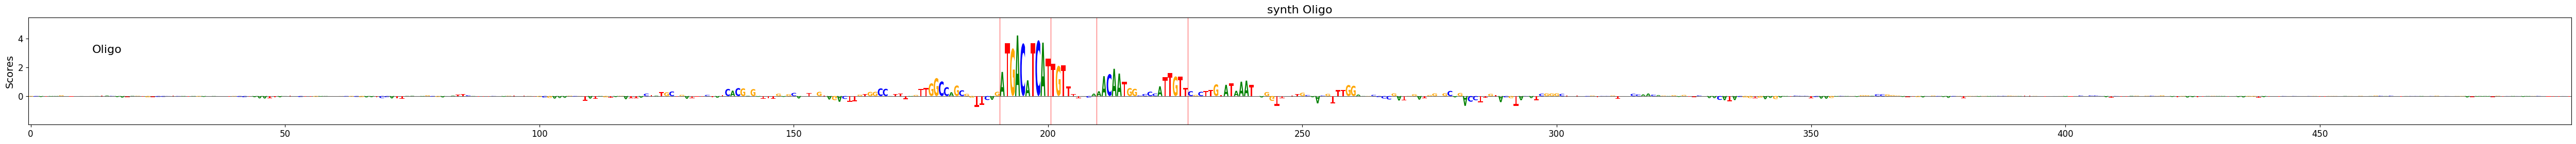

In [38]:
# see whether the model is actually using the implanted motifs
crested.pl.explain.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels="",
    class_labels=["Oligo"],
    zoom_n_bases=500,
    title="synth Oligo",
    height=3,
    highlight_positions=motif_positions,
)

### Using custom optimizers in enhancer design

The default optimization function that is used in enhancer design is a weighted difference function that maximizes the increase in accessibility for a target cell type while penalizing an increase in accessibility for other cell types.  

This is just one option though, many use cases exist where you might want to optimize for something different. For example, you could write an optimization function that maximizes the cosine similarity between a given accessibility vector and the designed sequence predicted accessibility vector.  

Below we give an example on how to write such a custom optimization function, wherein we will try to reach a specific accessibility value for some target cell type relative to other related cell types using the L2 distance.

By default, the {class}`~crested.tl.design.EnhancerOptimizer` expects an optimization function as input that has the arguments *mutated_predictions*, *original_predictions*, and *target*, and returns the index of the best mutated sequence. See its documentation for more information.

In [39]:
from sklearn.metrics import pairwise


def L2_distance(
    mutated_predictions: np.ndarray,
    original_prediction: np.ndarray,
    target: np.ndarray,
    classes_of_interest: list[int],
):
    """Calculate the L2 distance between the mutated predictions and the target class"""
    if len(original_prediction.shape) == 1:
        original_prediction = original_prediction[None]
    L2_sat_mut = pairwise.euclidean_distances(
        mutated_predictions[:, classes_of_interest],
        target[classes_of_interest].reshape(1, -1),
    )
    L2_baseline = pairwise.euclidean_distances(
        original_prediction[:, classes_of_interest],
        target[classes_of_interest].reshape(1, -1),
    )
    return np.argmax((L2_baseline - L2_sat_mut).squeeze())


L2_optimizer = crested.tl.design.EnhancerOptimizer(optimize_func=L2_distance)

target_cell_type = "L2_3IT"

classes_of_interest = [i for i, ct in enumerate(adata_specific.obs_names) if ct in ["L2_3IT", "L5ET", "L5IT", "L6IT"]]
target = np.array([20 if x == target_cell_type else 0 for x in adata_specific.obs_names])
intermediate, designed_sequences = crested.tl.design.in_silico_evolution(
    model=model,
    target=target,  # our optimization function now expects a target vector instead of a class index
    n_sequences=1,
    n_mutations=30,
    enhancer_optimizer=L2_optimizer,
    return_intermediate=True,
    no_mutation_flanks=(807, 807),
    acgt_distribution=acgt_distribution,
    classes_of_interest=classes_of_interest,  # additional kwargs will be passed to the optimizer
)

100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


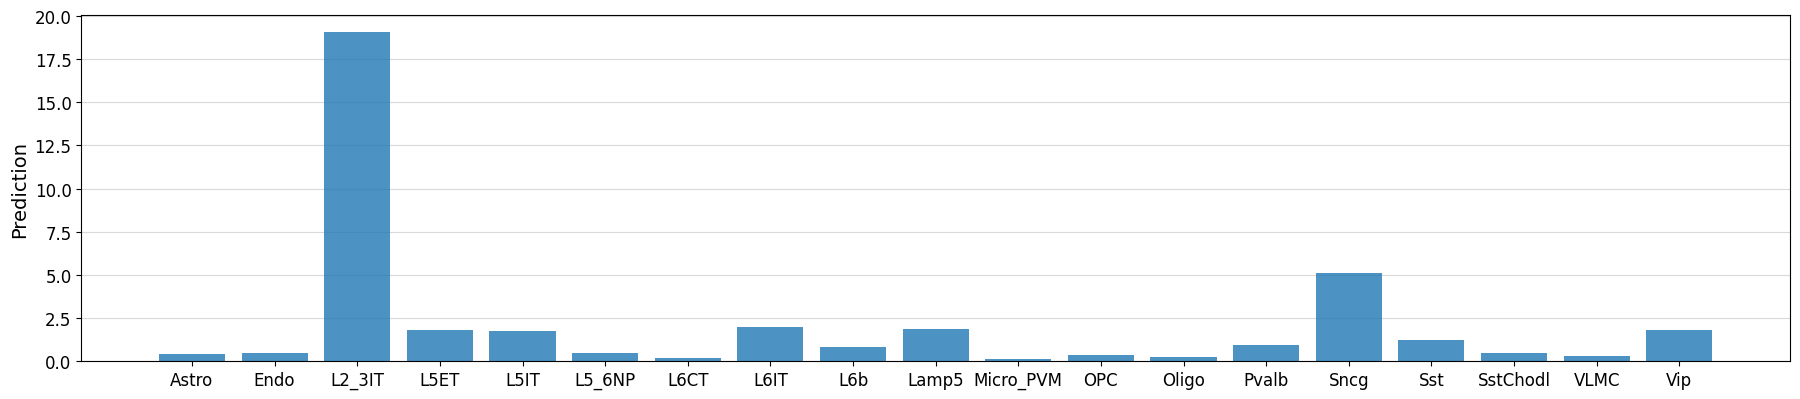

In [40]:
idx = 0
prediction = crested.tl.predict(designed_sequences[idx], model=model)
crested.pl.region.bar(prediction, classes=list(adata.obs_names))

In [41]:
class_idx = list(adata_specific.obs_names.get_indexer(["L2_3IT", "L5ET", "L5IT", "L6IT"]))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    designed_sequences[idx],
    target_idx=class_idx,
    model=model,
)

2026-02-16T13:13:57.133249+0100 INFO Calculating contribution scores for 4 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


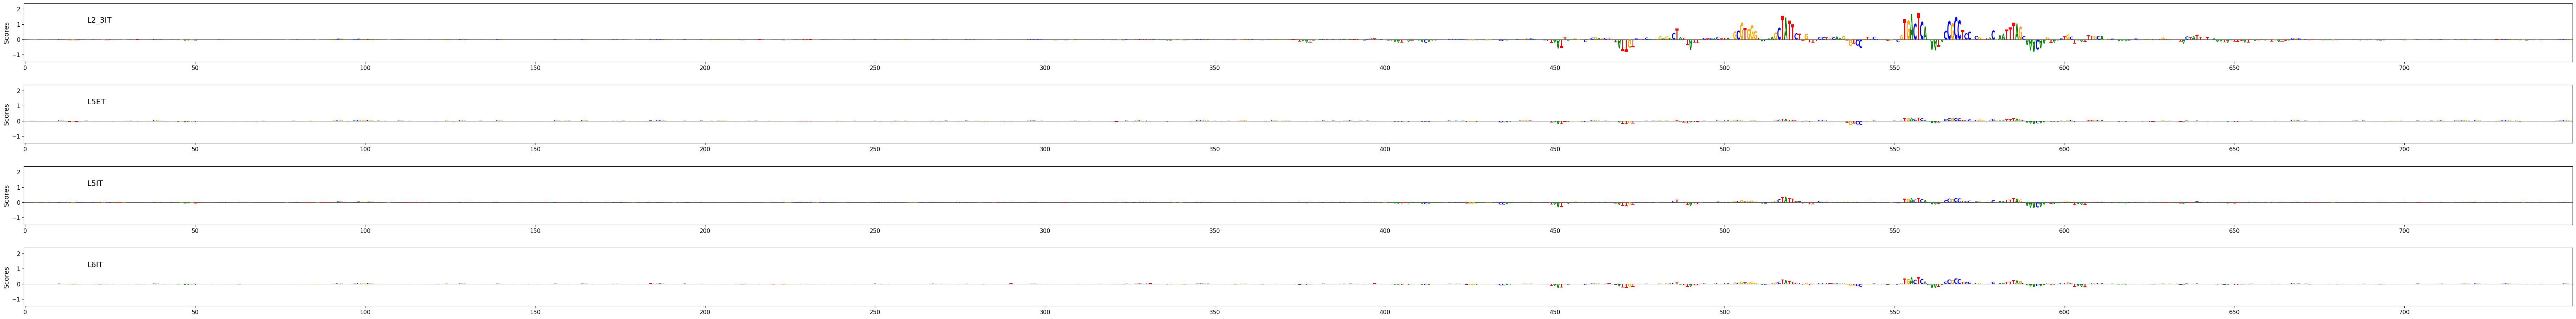

In [42]:
crested.pl.explain.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels="",
    class_labels=["L2_3IT", "L5ET", "L5IT", "L6IT"],
    zoom_n_bases=750,
)